# Base EBGAN

In [57]:
# EBGAN-BC  Code

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset

# Energy-based Model
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, action_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y)
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    return [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min 
            for _ in range(neg_count)]
    
def compute_gradient_penalty(energy_model, real_samples, fake_samples, device, lambda_gp=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    Args:
        energy_model (nn.Module): The energy-based model.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        device (torch.device): The device (CPU or GPU).
        lambda_gp (float): Coefficient for the gradient penalty.

    Returns:
        Tensor: The gradient penalty term.
    """
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)  # Match dimensions
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute energy model output for interpolated samples
    interpolated_energy = energy_model(interpolated[:, :real_samples.size(1)], interpolated[:, real_samples.size(1):])

    # Compute gradients of energy model output with respect to interpolated samples
    gradients = torch.autograd.grad(
        outputs=interpolated_energy,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_energy, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute L2 norm of gradients
    gradients_norm = gradients.view(gradients.size(0), -1).norm(2, dim=1)

    # Gradient penalty term
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

# Training function
def train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, 
          num_epochs, writer, y_min, y_max, neg_count, repeat_energy_updates, device):
    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss = 0.0
        i = 0
        for batch_x, batch_y in dataloader:
            x_input = batch_x.float().to(device)
            y_target = batch_y.float().to(device)
            
            # Update energy model
            for _ in range(repeat_energy_updates):
                # Generate counter samples
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Add generator samples to counter samples
                z = torch.randn(x_input.size(0), generator.latent_size, device=device)
                with torch.no_grad():
                    fake_y = generator(z, x_input)
                counter_samples.append(fake_y)
                
                # Compute energy model loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples)
                
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()
            
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size, device=device)
            fake_y = generator(z, x_input)
            g_loss = torch.mean(energy_model(x_input, fake_y))
            
            # Add gradient penalty
            # gradient_penalty = compute_gradient_penalty(energy_model, x_input, fake_y, device)
            # g_loss += gradient_penalty
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_g_loss += g_loss.item()
            
            # Log losses
            writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)
            i+=1
        
        scheduler_e.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss = epoch_g_loss / len(dataloader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Energy Loss: {avg_e_loss:.4f}, "
              f"Generator Loss: {avg_g_loss:.4f}")
        
        if (epoch +1 ==1) or ((epoch + 1)%25 == 0): 
            visualize_training(generator, energy_model, y_multi, x, y, device, epoch, save_path="visualizations")




In [100]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_training(generator, energy_model, y_multi, x, y, device, epoch = None, save_path="visualizations", num_query_points = 100):
    # Random sample the query points and get the predictions
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)

    predictions = []
    for point in query_points:
        query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
        z = torch.randn(1, generator.latent_size, device=device) 
        prediction = generator(z, query_points_tensor).detach().cpu().numpy()
        predictions.append(prediction.item())


    # Visualize the energy model output heatmap
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

    # Compute energy model output for each grid point
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
    energy_outputs = energy_outputs.reshape(100, 100)

    # Normalize every column of the heatmap
    # energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))
    # Normalize everything of the heatmap
    energy_outputs = (energy_outputs - energy_outputs.min()) / (energy_outputs.max() - energy_outputs.min())


    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
    # plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

    # Plot the function
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))

    for i, y_val in enumerate(y_vals_transposed):
        ax.plot(x_vals, y_val, linewidth=2)

    # Plot the samples and predictions
    ax.scatter(x, y, marker='x', color='black', label='Samples')
    ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid()
    ax.legend()
    if epoch: 
        ax.set_title(f'Energy-Based Model Predictions in Epoch: {epoch + 1}')
    else: 
        ax.set_title('Energy-Based Model Predictions')
    # plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
    plt.show()

In [59]:
parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size = 64
latent_size = 1
output_size = 1

num_epochs = 100
batch_size = 32
neg_count = 256
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)

True


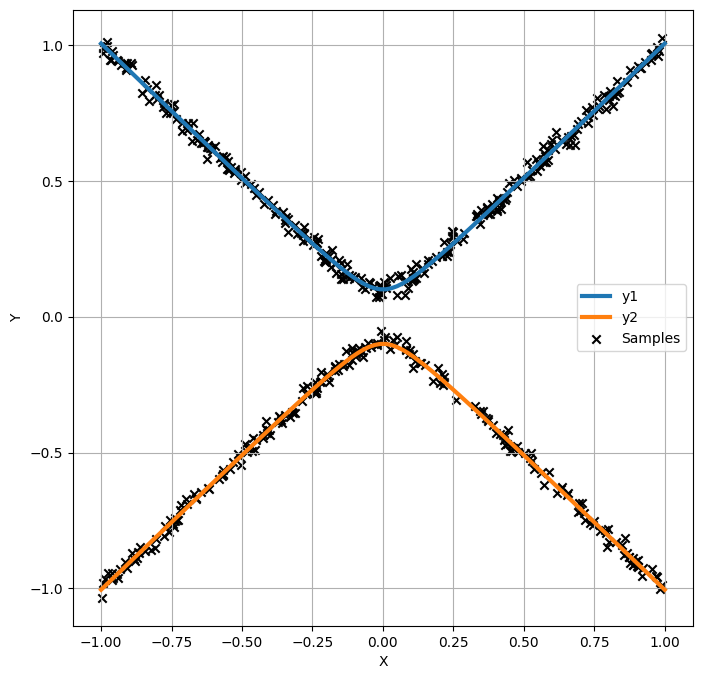

Epoch [1/100], Energy Loss: 5.4978, Generator Loss: -0.1611


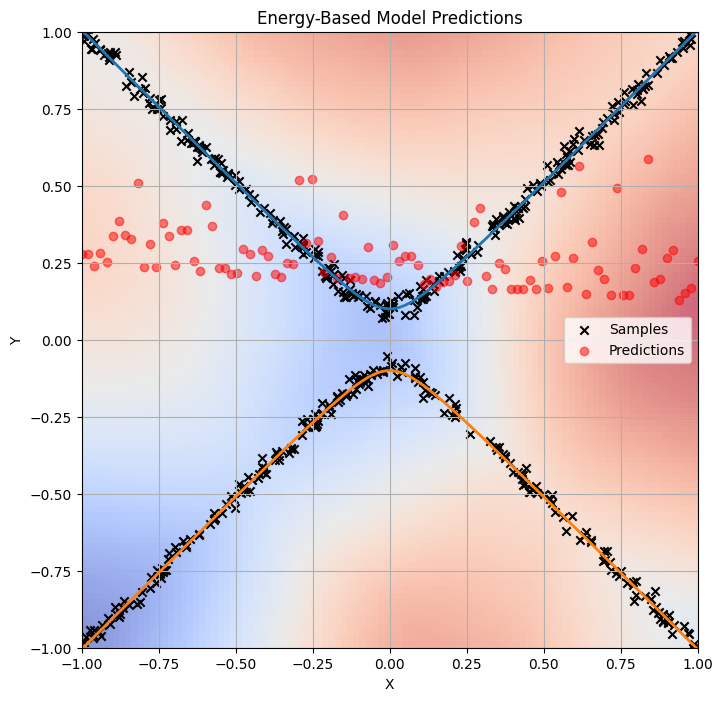

Epoch [2/100], Energy Loss: 5.2625, Generator Loss: -0.0765


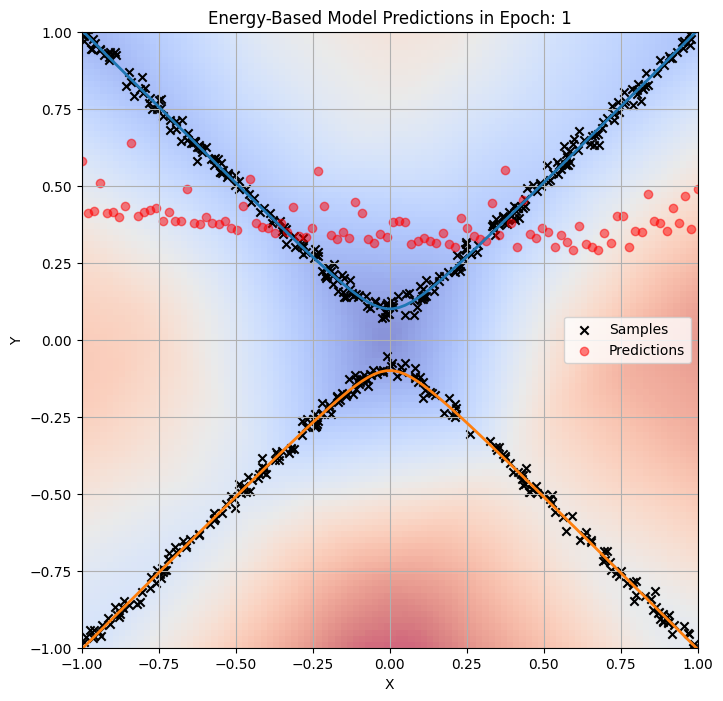

Epoch [3/100], Energy Loss: 4.8950, Generator Loss: 0.1453
Epoch [4/100], Energy Loss: 4.5833, Generator Loss: 0.5969
Epoch [5/100], Energy Loss: 4.3671, Generator Loss: 0.9305
Epoch [6/100], Energy Loss: 4.2201, Generator Loss: 1.2002
Epoch [7/100], Energy Loss: 4.1266, Generator Loss: 1.2149
Epoch [8/100], Energy Loss: 4.0766, Generator Loss: 1.2791
Epoch [9/100], Energy Loss: 4.0300, Generator Loss: 0.9592
Epoch [10/100], Energy Loss: 3.9363, Generator Loss: 0.7145
Epoch [11/100], Energy Loss: 3.9020, Generator Loss: 0.5334
Epoch [12/100], Energy Loss: 3.8494, Generator Loss: 0.7125
Epoch [13/100], Energy Loss: 3.7952, Generator Loss: 0.8235
Epoch [14/100], Energy Loss: 3.7644, Generator Loss: 0.9218
Epoch [15/100], Energy Loss: 3.7265, Generator Loss: 0.8965
Epoch [16/100], Energy Loss: 3.7037, Generator Loss: 1.0615
Epoch [17/100], Energy Loss: 3.7143, Generator Loss: 1.0524
Epoch [18/100], Energy Loss: 3.7214, Generator Loss: 1.1414
Epoch [19/100], Energy Loss: 3.6619, Generator 

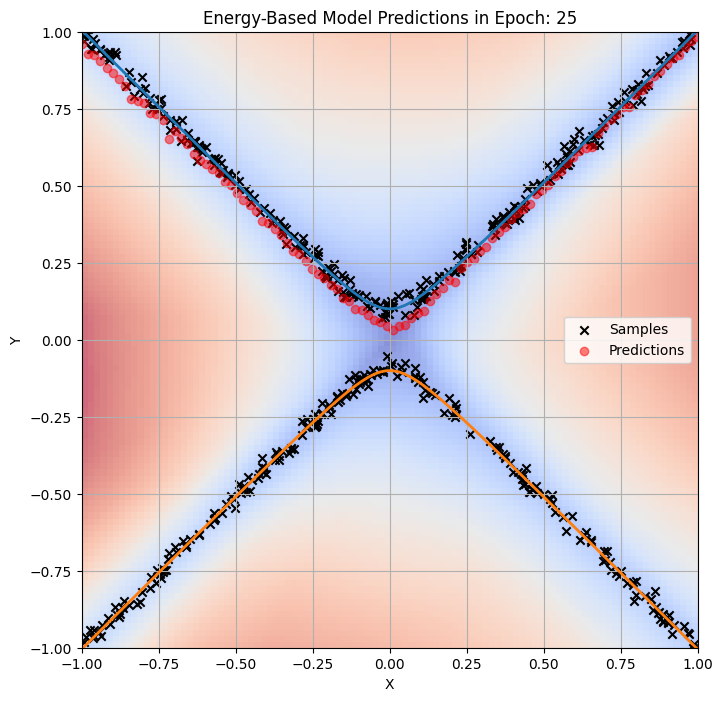

Epoch [27/100], Energy Loss: 3.5133, Generator Loss: 1.6142
Epoch [28/100], Energy Loss: 3.5183, Generator Loss: 1.3910
Epoch [29/100], Energy Loss: 3.4986, Generator Loss: 1.4301
Epoch [30/100], Energy Loss: 3.4756, Generator Loss: 1.5710
Epoch [31/100], Energy Loss: 3.4828, Generator Loss: 1.6303
Epoch [32/100], Energy Loss: 3.4849, Generator Loss: 1.5475
Epoch [33/100], Energy Loss: 3.4807, Generator Loss: 1.4935
Epoch [34/100], Energy Loss: 3.4803, Generator Loss: 1.5807
Epoch [35/100], Energy Loss: 3.4440, Generator Loss: 1.6967
Epoch [36/100], Energy Loss: 3.4333, Generator Loss: 1.7841
Epoch [37/100], Energy Loss: 3.4414, Generator Loss: 1.6532
Epoch [38/100], Energy Loss: 3.4392, Generator Loss: 1.8766
Epoch [39/100], Energy Loss: 3.4528, Generator Loss: 1.7869
Epoch [40/100], Energy Loss: 3.4339, Generator Loss: 1.8554
Epoch [41/100], Energy Loss: 3.3931, Generator Loss: 1.7838
Epoch [42/100], Energy Loss: 3.3827, Generator Loss: 1.7685
Epoch [43/100], Energy Loss: 3.3857, Gen

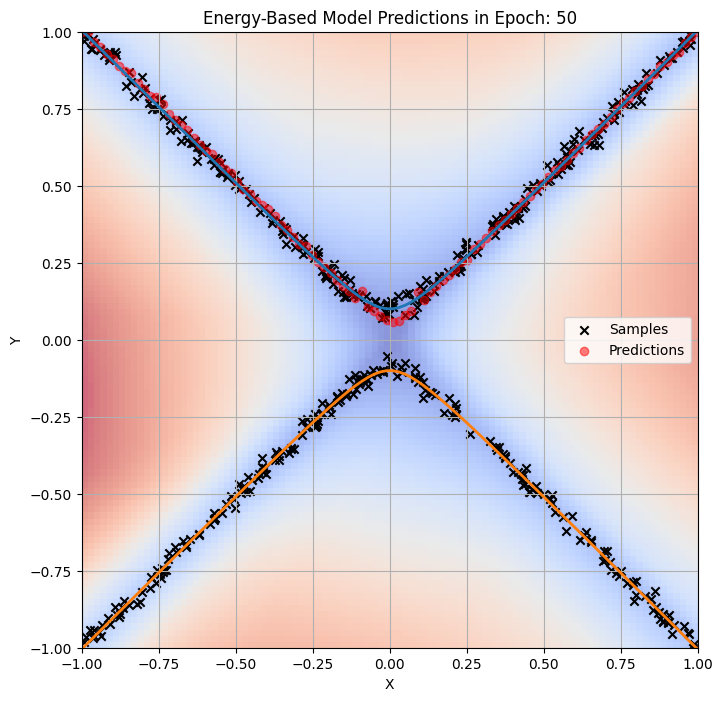

Epoch [52/100], Energy Loss: 3.3660, Generator Loss: 1.8648
Epoch [53/100], Energy Loss: 3.3534, Generator Loss: 1.8466
Epoch [54/100], Energy Loss: 3.3610, Generator Loss: 1.7566
Epoch [55/100], Energy Loss: 3.3436, Generator Loss: 1.8200
Epoch [56/100], Energy Loss: 3.3561, Generator Loss: 1.8162
Epoch [57/100], Energy Loss: 3.3426, Generator Loss: 1.8818
Epoch [58/100], Energy Loss: 3.3700, Generator Loss: 1.8109
Epoch [59/100], Energy Loss: 3.3467, Generator Loss: 1.8758
Epoch [60/100], Energy Loss: 3.3332, Generator Loss: 1.8413
Epoch [61/100], Energy Loss: 3.3251, Generator Loss: 1.7770
Epoch [62/100], Energy Loss: 3.3128, Generator Loss: 1.7247
Epoch [63/100], Energy Loss: 3.3143, Generator Loss: 1.7782
Epoch [64/100], Energy Loss: 3.3262, Generator Loss: 1.7359
Epoch [65/100], Energy Loss: 3.3095, Generator Loss: 1.7887
Epoch [66/100], Energy Loss: 3.3262, Generator Loss: 1.7282
Epoch [67/100], Energy Loss: 3.3145, Generator Loss: 1.8098
Epoch [68/100], Energy Loss: 3.3232, Gen

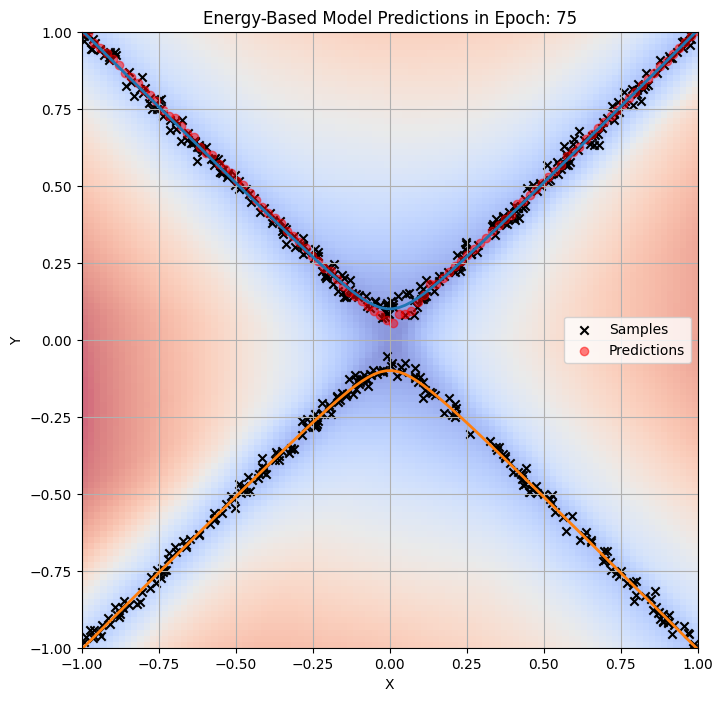

Epoch [77/100], Energy Loss: 3.3056, Generator Loss: 1.8774
Epoch [78/100], Energy Loss: 3.2935, Generator Loss: 1.7707
Epoch [79/100], Energy Loss: 3.2999, Generator Loss: 1.8206
Epoch [80/100], Energy Loss: 3.2960, Generator Loss: 1.8086
Epoch [81/100], Energy Loss: 3.2941, Generator Loss: 1.8007
Epoch [82/100], Energy Loss: 3.2858, Generator Loss: 1.8301
Epoch [83/100], Energy Loss: 3.2997, Generator Loss: 1.7761
Epoch [84/100], Energy Loss: 3.2918, Generator Loss: 1.7778
Epoch [85/100], Energy Loss: 3.2839, Generator Loss: 1.7688
Epoch [86/100], Energy Loss: 3.2896, Generator Loss: 1.7856
Epoch [87/100], Energy Loss: 3.2902, Generator Loss: 1.7587
Epoch [88/100], Energy Loss: 3.2900, Generator Loss: 1.7979
Epoch [89/100], Energy Loss: 3.2866, Generator Loss: 1.7814
Epoch [90/100], Energy Loss: 3.2978, Generator Loss: 1.7892
Epoch [91/100], Energy Loss: 3.2893, Generator Loss: 1.7925
Epoch [92/100], Energy Loss: 3.2957, Generator Loss: 1.8224
Epoch [93/100], Energy Loss: 3.2860, Gen

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

# Diversity and Gradient Penalties

In [86]:
# EBGAN-BC  Code

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset

# Energy-based Model
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, action_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y) # condition, data
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    return [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min 
            for _ in range(neg_count)]
    
def compute_gradient_penalty(energy_model, condition, real_samples, fake_samples, device, lambda_gp=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    Args:
        energy_model (nn.Module): The energy-based model.
        condition (Tensor): The condition on which the model is build on.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        device (torch.device): The device (CPU or GPU).
        lambda_gp (float): Coefficient for the gradient penalty.

    Returns:
        Tensor: The gradient penalty term.
    """
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)  # Match dimensions
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute energy model output for interpolated samples
    interpolated_energy = energy_model(condition, interpolated)

    # Compute gradients of energy model output with respect to interpolated samples
    gradients = torch.autograd.grad(
        outputs=interpolated_energy,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_energy, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute L2 norm of gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Gradient penalty term
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

# Training function
def train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, 
          num_epochs, writer, y_min, y_max, neg_count, repeat_energy_updates, device, lambda_gp = 10, diversity_weight = 0.1):
    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss = 0.0
        epoch_g_loss_i = 0.0
        epoch_g_penalty = 0.0
        epoch_diversity = 0.0
        i = 0
        for batch_x, batch_y in dataloader:
            x_input = batch_x.float().to(device) # conditon
            y_target = batch_y.float().to(device) # real data
            
            # Update energy model
            for _ in range(repeat_energy_updates):
                # Generate counter samples
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Add generator samples to counter samples
                z = torch.randn(x_input.size(0), generator.latent_size, device=device)
                with torch.no_grad():
                    fake_y = generator(z, x_input) # fake data
                counter_samples.append(fake_y)
                
                # Compute energy model loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples)
                
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()
            
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size, device=device)
            fake_y = generator(z, x_input)
            g_loss = torch.mean(energy_model(x_input, fake_y))
            epoch_g_loss_i += g_loss.item()
            
            # Add gradient penalty
            gradient_penalty = compute_gradient_penalty(energy_model, x_input, y_target, fake_y, device, lambda_gp)
            # g_loss += gradient_penalty
            
            # Add diversity loss
            diversity_loss = -torch.var(generator(z, x_input), dim=0).mean()
            g_loss += diversity_weight * diversity_loss
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_g_loss += g_loss.item()
            epoch_g_penalty += gradient_penalty.item()
            epoch_diversity += diversity_loss.item()
            
            # Log losses
            writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)
            i+=1
        
        scheduler_e.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_g_loss_i = epoch_g_loss_i / len(dataloader)
        avg_g_pen = epoch_g_penalty / len(dataloader)
        avg_div = epoch_diversity / len(dataloader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Energy Loss: {avg_e_loss:.4f}, "
              f"Generator Loss: {avg_g_loss:.4f}, "
              f"Generator Loss (Only G): {avg_g_loss_i:.4f}, "
              f"Gradient Penalty: {avg_g_pen:.4f}, "
              f"Diversity: {avg_div:.4f}, ")
        
        if (epoch)%25 == 0: 
            visualize_training(generator, energy_model, y_multi, x, y, device, epoch, save_path="visualizations")



In [87]:
parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size = 64
latent_size = 1
output_size = 1

num_epochs = 100
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

learning_rate_e = 0.001
learning_rate_g = 0.0005
lambda_gp = 1
diversity_weight = 0.01

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)

True


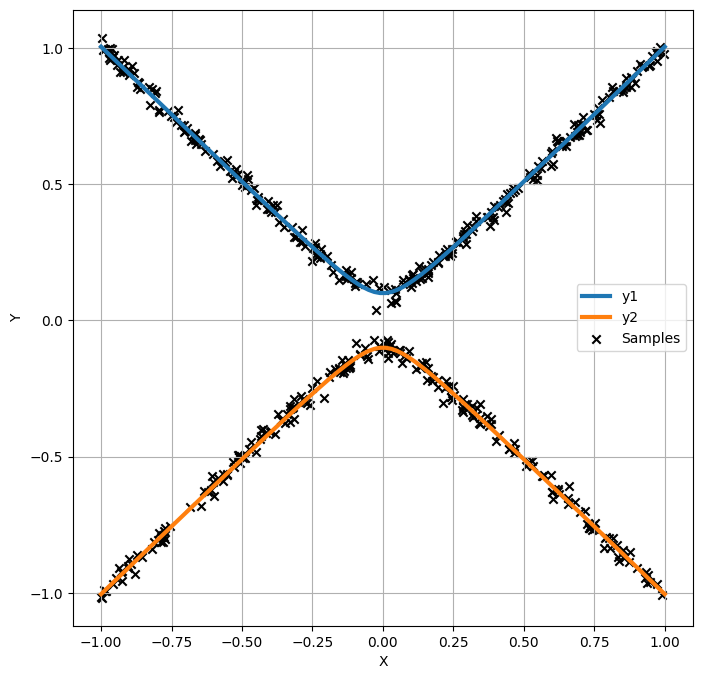

Epoch [1/100], Energy Loss: 5.5326, Generator Loss: 0.1014, Generator Loss (Only G): 0.1014, Gradient Penalty: 0.7278, Diversity: -0.0044, 


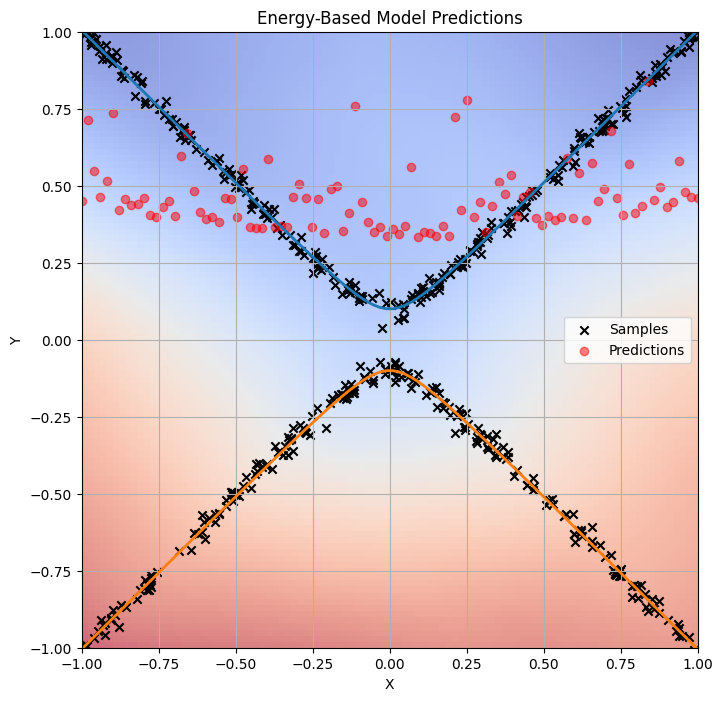

Epoch [2/100], Energy Loss: 5.5119, Generator Loss: 0.0521, Generator Loss (Only G): 0.0522, Gradient Penalty: 0.7357, Diversity: -0.0143, 
Epoch [3/100], Energy Loss: 5.4903, Generator Loss: 0.0561, Generator Loss (Only G): 0.0564, Gradient Penalty: 0.7631, Diversity: -0.0378, 
Epoch [4/100], Energy Loss: 5.4608, Generator Loss: 0.1486, Generator Loss (Only G): 0.1491, Gradient Penalty: 0.6836, Diversity: -0.0482, 
Epoch [5/100], Energy Loss: 5.4208, Generator Loss: 0.2250, Generator Loss (Only G): 0.2252, Gradient Penalty: 0.4736, Diversity: -0.0211, 
Epoch [6/100], Energy Loss: 5.3732, Generator Loss: 0.2673, Generator Loss (Only G): 0.2674, Gradient Penalty: 0.2736, Diversity: -0.0093, 
Epoch [7/100], Energy Loss: 5.3097, Generator Loss: 0.3430, Generator Loss (Only G): 0.3431, Gradient Penalty: 0.2400, Diversity: -0.0127, 
Epoch [8/100], Energy Loss: 5.2392, Generator Loss: 0.4435, Generator Loss (Only G): 0.4437, Gradient Penalty: 0.3491, Diversity: -0.0172, 
Epoch [9/100], Energ

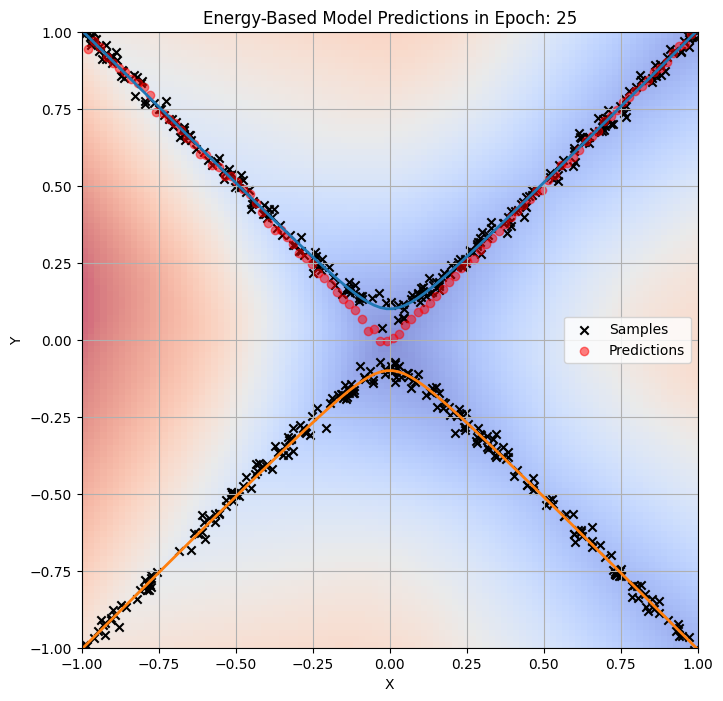

Epoch [27/100], Energy Loss: 4.2271, Generator Loss: 0.5163, Generator Loss (Only G): 0.5172, Gradient Penalty: 33.7529, Diversity: -0.0903, 
Epoch [28/100], Energy Loss: 4.2246, Generator Loss: 0.4609, Generator Loss (Only G): 0.4617, Gradient Penalty: 35.3802, Diversity: -0.0893, 
Epoch [29/100], Energy Loss: 4.1960, Generator Loss: 0.4925, Generator Loss (Only G): 0.4933, Gradient Penalty: 36.2272, Diversity: -0.0858, 
Epoch [30/100], Energy Loss: 4.1876, Generator Loss: 0.4924, Generator Loss (Only G): 0.4933, Gradient Penalty: 36.6451, Diversity: -0.0865, 
Epoch [31/100], Energy Loss: 4.1720, Generator Loss: 0.3952, Generator Loss (Only G): 0.3961, Gradient Penalty: 40.6610, Diversity: -0.0886, 
Epoch [32/100], Energy Loss: 4.1657, Generator Loss: 0.4468, Generator Loss (Only G): 0.4477, Gradient Penalty: 40.6107, Diversity: -0.0884, 
Epoch [33/100], Energy Loss: 4.1563, Generator Loss: 0.5136, Generator Loss (Only G): 0.5144, Gradient Penalty: 42.4835, Diversity: -0.0877, 
Epoch 

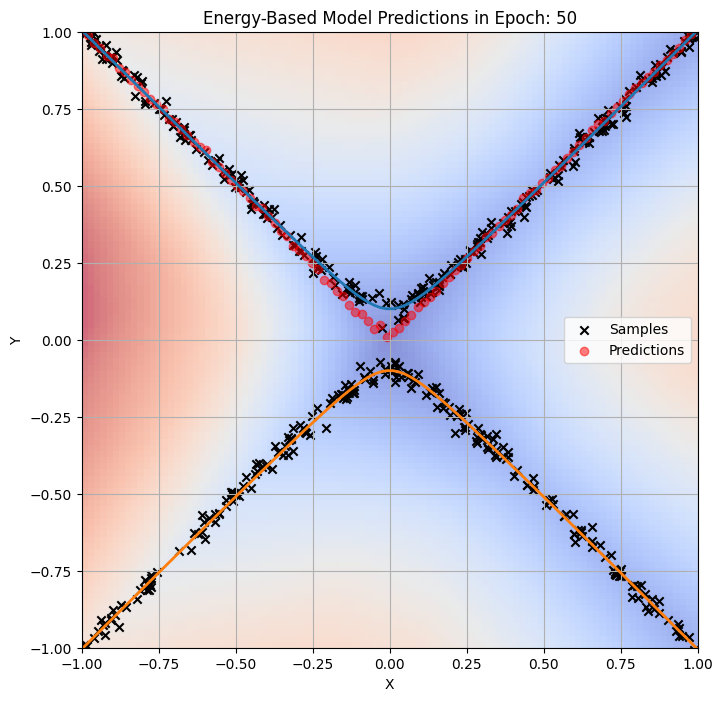

Epoch [52/100], Energy Loss: 3.9858, Generator Loss: 0.7143, Generator Loss (Only G): 0.7152, Gradient Penalty: 77.5292, Diversity: -0.0857, 
Epoch [53/100], Energy Loss: 3.9832, Generator Loss: 0.7736, Generator Loss (Only G): 0.7745, Gradient Penalty: 78.5430, Diversity: -0.0880, 
Epoch [54/100], Energy Loss: 3.9711, Generator Loss: 0.7427, Generator Loss (Only G): 0.7436, Gradient Penalty: 77.0364, Diversity: -0.0897, 
Epoch [55/100], Energy Loss: 3.9637, Generator Loss: 0.7215, Generator Loss (Only G): 0.7224, Gradient Penalty: 78.2236, Diversity: -0.0887, 
Epoch [56/100], Energy Loss: 3.9688, Generator Loss: 0.7316, Generator Loss (Only G): 0.7324, Gradient Penalty: 76.7323, Diversity: -0.0870, 
Epoch [57/100], Energy Loss: 3.9669, Generator Loss: 0.7558, Generator Loss (Only G): 0.7566, Gradient Penalty: 81.7283, Diversity: -0.0865, 
Epoch [58/100], Energy Loss: 3.9606, Generator Loss: 0.7514, Generator Loss (Only G): 0.7523, Gradient Penalty: 81.0686, Diversity: -0.0883, 
Epoch 

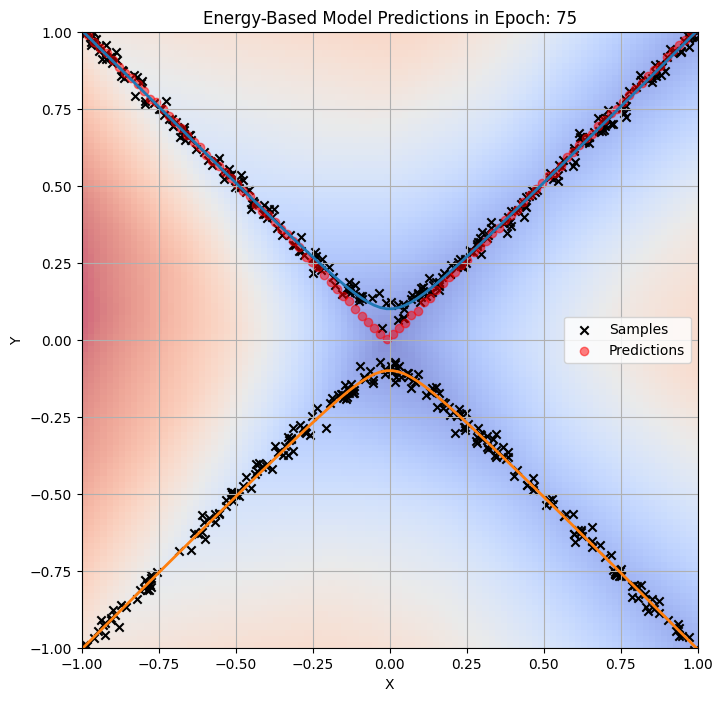

Epoch [77/100], Energy Loss: 3.9035, Generator Loss: 0.8147, Generator Loss (Only G): 0.8156, Gradient Penalty: 95.2868, Diversity: -0.0852, 
Epoch [78/100], Energy Loss: 3.9028, Generator Loss: 0.8164, Generator Loss (Only G): 0.8173, Gradient Penalty: 101.9120, Diversity: -0.0877, 
Epoch [79/100], Energy Loss: 3.9072, Generator Loss: 0.8057, Generator Loss (Only G): 0.8066, Gradient Penalty: 96.2490, Diversity: -0.0896, 
Epoch [80/100], Energy Loss: 3.9092, Generator Loss: 0.8401, Generator Loss (Only G): 0.8410, Gradient Penalty: 95.4899, Diversity: -0.0874, 
Epoch [81/100], Energy Loss: 3.8993, Generator Loss: 0.8307, Generator Loss (Only G): 0.8316, Gradient Penalty: 94.0549, Diversity: -0.0865, 
Epoch [82/100], Energy Loss: 3.8916, Generator Loss: 0.8465, Generator Loss (Only G): 0.8474, Gradient Penalty: 101.4051, Diversity: -0.0896, 
Epoch [83/100], Energy Loss: 3.9004, Generator Loss: 0.8101, Generator Loss (Only G): 0.8109, Gradient Penalty: 99.5291, Diversity: -0.0882, 
Epoc

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device, lambda_gp = lambda_gp, diversity_weight = diversity_weight)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

# Latent space noise scaling

In [93]:
# EBGAN-BC  Code

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset

# Energy-based Model
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, action_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y) # condition, data
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    return [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min 
            for _ in range(neg_count)]
    
def compute_gradient_penalty(energy_model, condition, real_samples, fake_samples, device, lambda_gp=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    Args:
        energy_model (nn.Module): The energy-based model.
        condition (Tensor): The condition on which the model is build on.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        device (torch.device): The device (CPU or GPU).
        lambda_gp (float): Coefficient for the gradient penalty.

    Returns:
        Tensor: The gradient penalty term.
    """
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)  # Match dimensions
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute energy model output for interpolated samples
    interpolated_energy = energy_model(condition, interpolated)

    # Compute gradients of energy model output with respect to interpolated samples
    gradients = torch.autograd.grad(
        outputs=interpolated_energy,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_energy, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute L2 norm of gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Gradient penalty term
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

# Training function
def train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, 
          num_epochs, writer, y_min, y_max, neg_count, repeat_energy_updates, device, lambda_gp = 10, diversity_weight = 0.1, max_noise_scale = 0.1):
    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss = 0.0
        epoch_g_loss_i = 0.0
        epoch_g_penalty = 0.0
        epoch_diversity = 0.0
        i = 0
        noise_scale = max(max_noise_scale, 1 - epoch / num_epochs)  # Decrease over time
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.float().to(device) # conditon
            y_target = batch_y.float().to(device) # real data
            
            # Update energy model
            for _ in range(repeat_energy_updates):
                # Generate counter samples
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Add generator samples to counter samples
                z = torch.randn(x_input.size(0), generator.latent_size, device=device) * noise_scale

                with torch.no_grad():
                    fake_y = generator(z, x_input) # fake data
                counter_samples.append(fake_y)
                
                # Compute energy model loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples)
                
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()
            
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size, device=device)
            
            fake_y = generator(z, x_input)
            g_loss = torch.mean(energy_model(x_input, fake_y))
            epoch_g_loss_i += g_loss.item()
            
            # Add gradient penalty
            gradient_penalty = compute_gradient_penalty(energy_model, x_input, y_target, fake_y, device, lambda_gp)
            # g_loss += gradient_penalty
            
            # Add diversity loss
            diversity_loss = -torch.var(generator(z, x_input), dim=0).mean()
            g_loss += diversity_weight * diversity_loss
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_g_loss += g_loss.item()
            epoch_g_penalty += gradient_penalty.item()
            epoch_diversity += diversity_loss.item()
            
            # Log losses
            writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)
            i+=1
        
        scheduler_e.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_g_loss_i = epoch_g_loss_i / len(dataloader)
        avg_g_pen = epoch_g_penalty / len(dataloader)
        avg_div = epoch_diversity / len(dataloader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Energy Loss: {avg_e_loss:.4f}, "
              f"Generator Loss: {avg_g_loss:.4f}, "
              f"Generator Loss (Only G): {avg_g_loss_i:.4f}, "
              f"Gradient Penalty: {avg_g_pen:.4f}, "
              f"Diversity: {avg_div:.4f}, ")
        
        if (epoch + 1 == 1) or (epoch + 1) %25 == 0: 
            visualize_training(generator, energy_model, y_multi, x, y, device, epoch, save_path="visualizations")



True


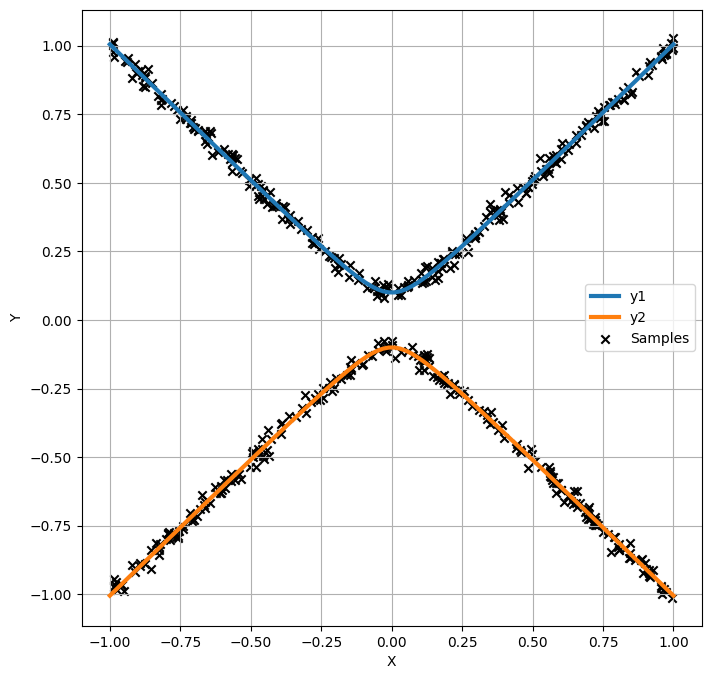

Epoch [1/100], Energy Loss: 5.5430, Generator Loss: -0.2599, Generator Loss (Only G): -0.2599, Gradient Penalty: 0.0000, Diversity: -0.0100, 


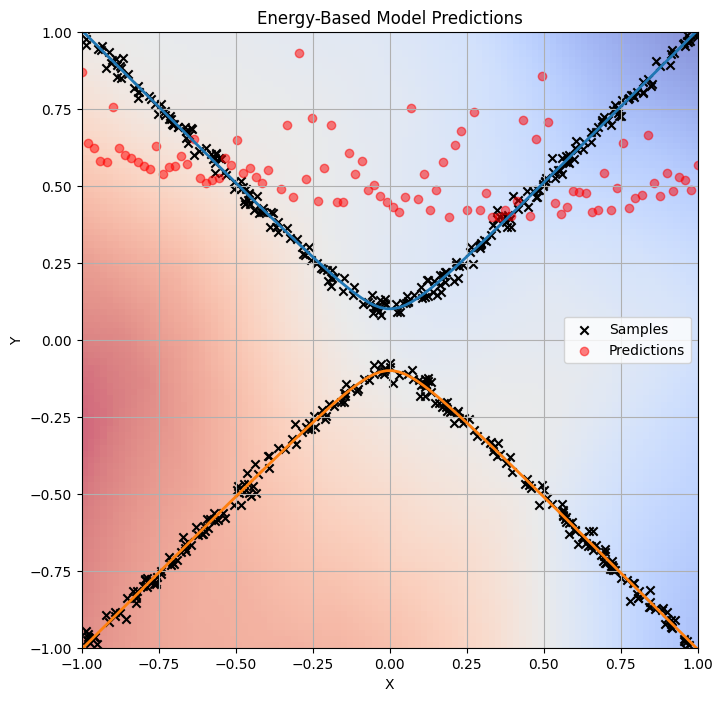

Epoch [2/100], Energy Loss: 5.5278, Generator Loss: -0.3369, Generator Loss (Only G): -0.3369, Gradient Penalty: 0.0000, Diversity: -0.0348, 
Epoch [3/100], Energy Loss: 5.5124, Generator Loss: -0.3728, Generator Loss (Only G): -0.3728, Gradient Penalty: 0.0000, Diversity: -0.0468, 
Epoch [4/100], Energy Loss: 5.4925, Generator Loss: -0.4354, Generator Loss (Only G): -0.4354, Gradient Penalty: 0.0000, Diversity: -0.1291, 
Epoch [5/100], Energy Loss: 5.4649, Generator Loss: -0.5681, Generator Loss (Only G): -0.5681, Gradient Penalty: 0.0000, Diversity: -0.3278, 
Epoch [6/100], Energy Loss: 5.4312, Generator Loss: -0.6195, Generator Loss (Only G): -0.6195, Gradient Penalty: 0.0000, Diversity: -0.6908, 
Epoch [7/100], Energy Loss: 5.3846, Generator Loss: 0.0860, Generator Loss (Only G): 0.0860, Gradient Penalty: 0.0000, Diversity: -1.4903, 
Epoch [8/100], Energy Loss: 5.3310, Generator Loss: 0.2472, Generator Loss (Only G): 0.2472, Gradient Penalty: 0.0000, Diversity: -1.2562, 
Epoch [9/1

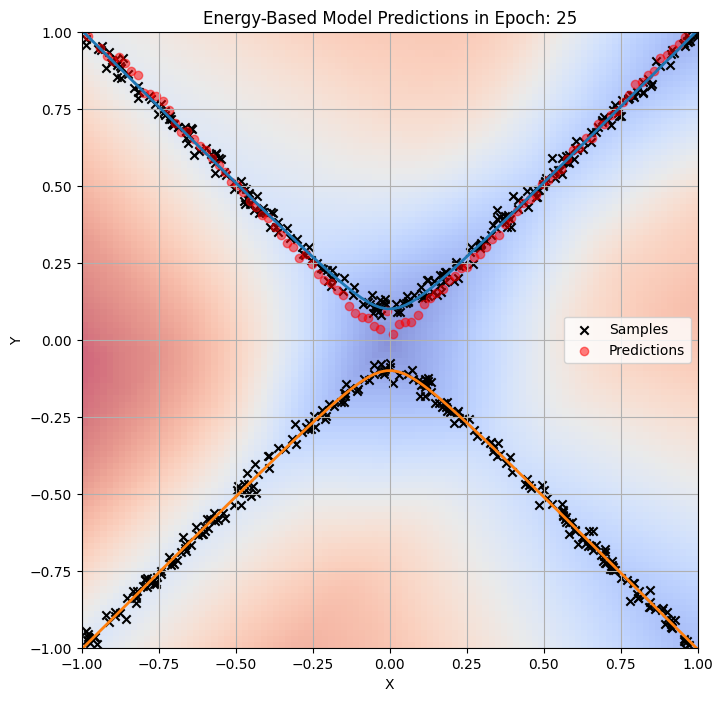

Epoch [27/100], Energy Loss: 4.4086, Generator Loss: -1.5862, Generator Loss (Only G): -1.5862, Gradient Penalty: 0.0000, Diversity: -0.0867, 
Epoch [28/100], Energy Loss: 4.3904, Generator Loss: -1.5618, Generator Loss (Only G): -1.5618, Gradient Penalty: 0.0000, Diversity: -0.0861, 
Epoch [29/100], Energy Loss: 4.3793, Generator Loss: -1.5332, Generator Loss (Only G): -1.5332, Gradient Penalty: 0.0000, Diversity: -0.0837, 
Epoch [30/100], Energy Loss: 4.3616, Generator Loss: -1.5119, Generator Loss (Only G): -1.5119, Gradient Penalty: 0.0000, Diversity: -0.0864, 
Epoch [31/100], Energy Loss: 4.3549, Generator Loss: -1.4833, Generator Loss (Only G): -1.4833, Gradient Penalty: 0.0000, Diversity: -0.0836, 
Epoch [32/100], Energy Loss: 4.3279, Generator Loss: -1.4856, Generator Loss (Only G): -1.4856, Gradient Penalty: 0.0000, Diversity: -0.0872, 
Epoch [33/100], Energy Loss: 4.3151, Generator Loss: -1.3569, Generator Loss (Only G): -1.3569, Gradient Penalty: 0.0000, Diversity: -0.0851, 

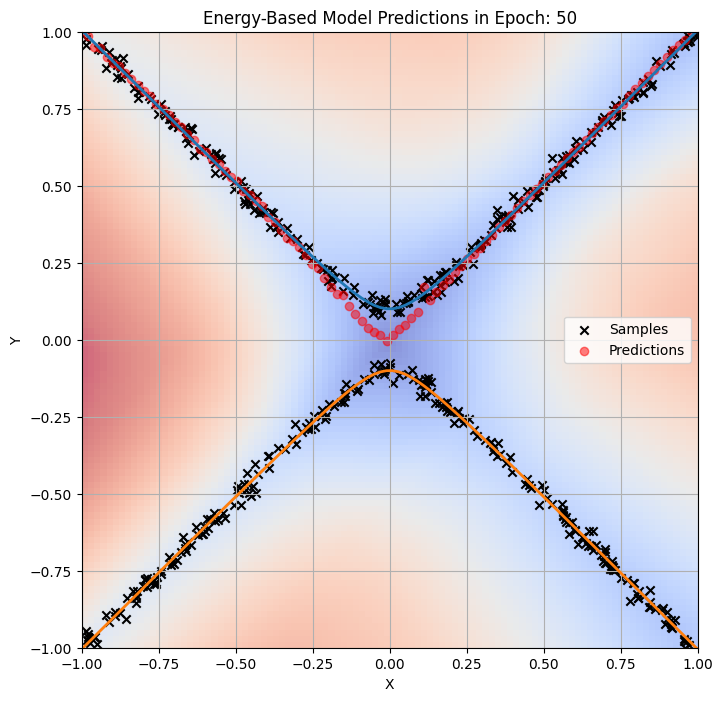

Epoch [52/100], Energy Loss: 4.1559, Generator Loss: -1.1718, Generator Loss (Only G): -1.1718, Gradient Penalty: 0.0000, Diversity: -0.0849, 
Epoch [53/100], Energy Loss: 4.1445, Generator Loss: -1.1906, Generator Loss (Only G): -1.1906, Gradient Penalty: 0.0000, Diversity: -0.0856, 
Epoch [54/100], Energy Loss: 4.1441, Generator Loss: -1.1463, Generator Loss (Only G): -1.1463, Gradient Penalty: 0.0000, Diversity: -0.0852, 
Epoch [55/100], Energy Loss: 4.1353, Generator Loss: -1.1893, Generator Loss (Only G): -1.1893, Gradient Penalty: 0.0000, Diversity: -0.0854, 
Epoch [56/100], Energy Loss: 4.1309, Generator Loss: -1.1619, Generator Loss (Only G): -1.1619, Gradient Penalty: 0.0000, Diversity: -0.0840, 
Epoch [57/100], Energy Loss: 4.1227, Generator Loss: -1.1371, Generator Loss (Only G): -1.1371, Gradient Penalty: 0.0000, Diversity: -0.0847, 
Epoch [58/100], Energy Loss: 4.1171, Generator Loss: -1.1692, Generator Loss (Only G): -1.1692, Gradient Penalty: 0.0000, Diversity: -0.0858, 

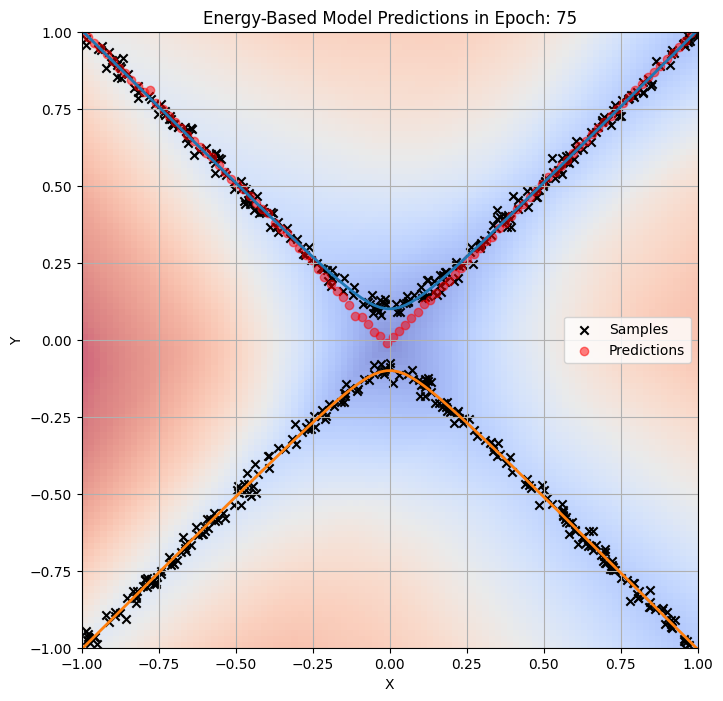

Epoch [77/100], Energy Loss: 4.0783, Generator Loss: -1.0238, Generator Loss (Only G): -1.0238, Gradient Penalty: 0.0000, Diversity: -0.0850, 
Epoch [78/100], Energy Loss: 4.0700, Generator Loss: -1.0190, Generator Loss (Only G): -1.0190, Gradient Penalty: 0.0000, Diversity: -0.0826, 
Epoch [79/100], Energy Loss: 4.0622, Generator Loss: -1.0238, Generator Loss (Only G): -1.0238, Gradient Penalty: 0.0000, Diversity: -0.0840, 
Epoch [80/100], Energy Loss: 4.0645, Generator Loss: -0.9760, Generator Loss (Only G): -0.9760, Gradient Penalty: 0.0000, Diversity: -0.0845, 
Epoch [81/100], Energy Loss: 4.0606, Generator Loss: -0.9978, Generator Loss (Only G): -0.9978, Gradient Penalty: 0.0000, Diversity: -0.0860, 
Epoch [82/100], Energy Loss: 4.0581, Generator Loss: -1.0061, Generator Loss (Only G): -1.0061, Gradient Penalty: 0.0000, Diversity: -0.0847, 
Epoch [83/100], Energy Loss: 4.0538, Generator Loss: -0.9892, Generator Loss (Only G): -0.9892, Gradient Penalty: 0.0000, Diversity: -0.0846, 

In [90]:
parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size = 64
latent_size = 1
output_size = 1

num_epochs = 100
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

learning_rate_e = 0.001
learning_rate_g = 0.0005
lambda_gp = 0
diversity_weight = 0.00
max_noise_scale = 0.1

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)


import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device, lambda_gp = lambda_gp, diversity_weight = diversity_weight, max_noise_scale = max_noise_scale)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

## Noise max = 0.5 

True


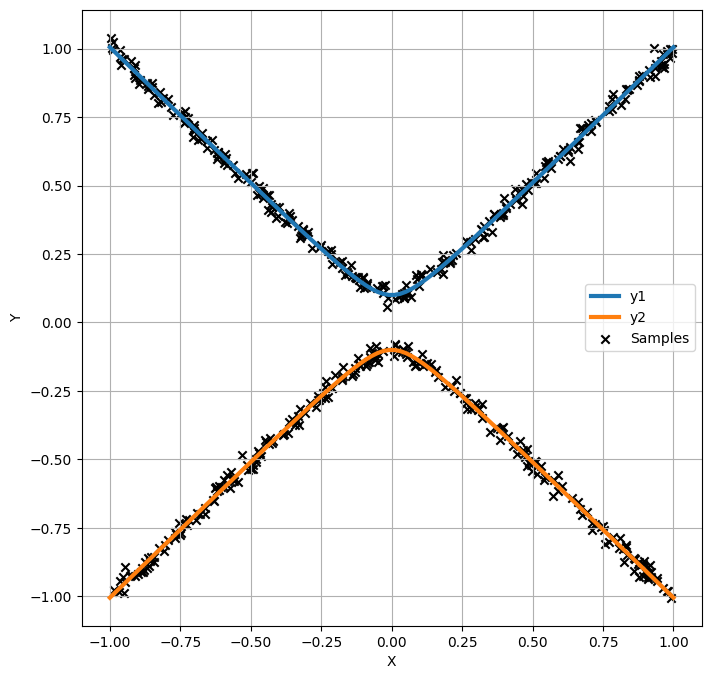

Epoch [1/100], Energy Loss: 5.5479, Generator Loss: 0.0551, Generator Loss (Only G): 0.0551, Gradient Penalty: 0.0000, Diversity: -0.0100, 


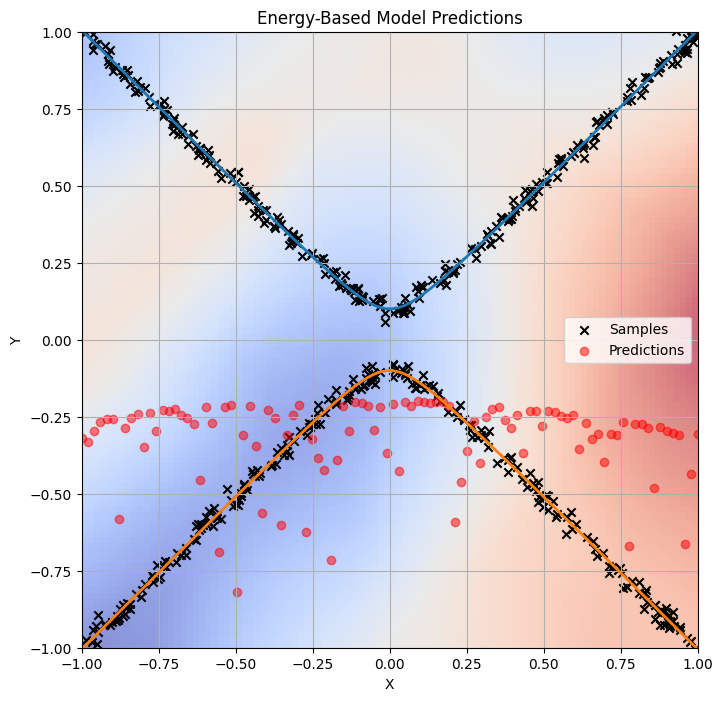

Epoch [2/100], Energy Loss: 5.5310, Generator Loss: 0.0369, Generator Loss (Only G): 0.0369, Gradient Penalty: 0.0000, Diversity: -0.0334, 
Epoch [3/100], Energy Loss: 5.5116, Generator Loss: 0.0093, Generator Loss (Only G): 0.0093, Gradient Penalty: 0.0000, Diversity: -0.0402, 
Epoch [4/100], Energy Loss: 5.4840, Generator Loss: 0.0091, Generator Loss (Only G): 0.0091, Gradient Penalty: 0.0000, Diversity: -0.0295, 
Epoch [5/100], Energy Loss: 5.4463, Generator Loss: -0.0428, Generator Loss (Only G): -0.0428, Gradient Penalty: 0.0000, Diversity: -0.0254, 
Epoch [6/100], Energy Loss: 5.3920, Generator Loss: -0.0974, Generator Loss (Only G): -0.0974, Gradient Penalty: 0.0000, Diversity: -0.0401, 
Epoch [7/100], Energy Loss: 5.3286, Generator Loss: -0.2315, Generator Loss (Only G): -0.2315, Gradient Penalty: 0.0000, Diversity: -0.0756, 
Epoch [8/100], Energy Loss: 5.2562, Generator Loss: -0.3342, Generator Loss (Only G): -0.3342, Gradient Penalty: 0.0000, Diversity: -0.1231, 
Epoch [9/100

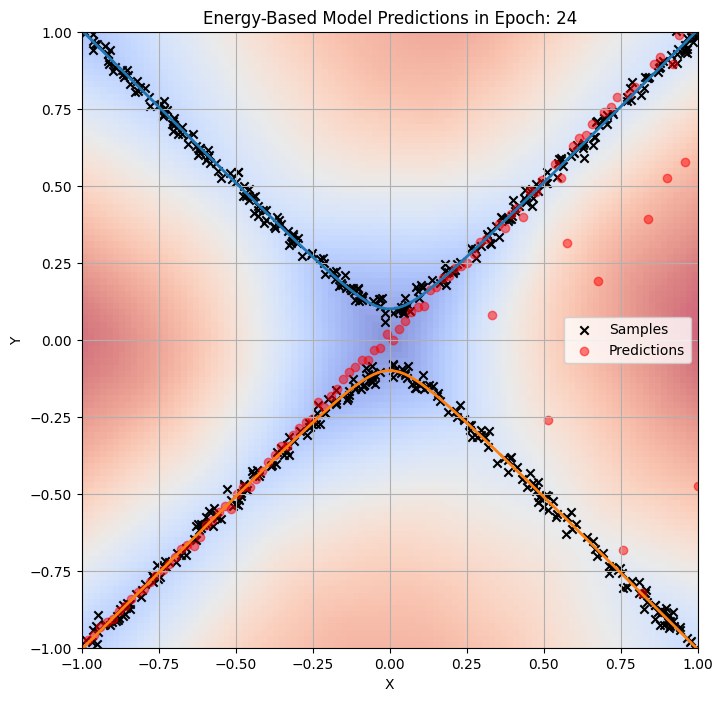

Epoch [26/100], Energy Loss: 4.3962, Generator Loss: -1.7137, Generator Loss (Only G): -1.7137, Gradient Penalty: 0.0000, Diversity: -0.3211, 
Epoch [27/100], Energy Loss: 4.3862, Generator Loss: -1.7544, Generator Loss (Only G): -1.7544, Gradient Penalty: 0.0000, Diversity: -0.3247, 
Epoch [28/100], Energy Loss: 4.3708, Generator Loss: -1.7640, Generator Loss (Only G): -1.7640, Gradient Penalty: 0.0000, Diversity: -0.3419, 
Epoch [29/100], Energy Loss: 4.3612, Generator Loss: -1.8057, Generator Loss (Only G): -1.8057, Gradient Penalty: 0.0000, Diversity: -0.3327, 
Epoch [30/100], Energy Loss: 4.3394, Generator Loss: -1.6431, Generator Loss (Only G): -1.6431, Gradient Penalty: 0.0000, Diversity: -0.3087, 
Epoch [31/100], Energy Loss: 4.3267, Generator Loss: -1.7408, Generator Loss (Only G): -1.7408, Gradient Penalty: 0.0000, Diversity: -0.3296, 
Epoch [32/100], Energy Loss: 4.3042, Generator Loss: -1.7480, Generator Loss (Only G): -1.7480, Gradient Penalty: 0.0000, Diversity: -0.3217, 

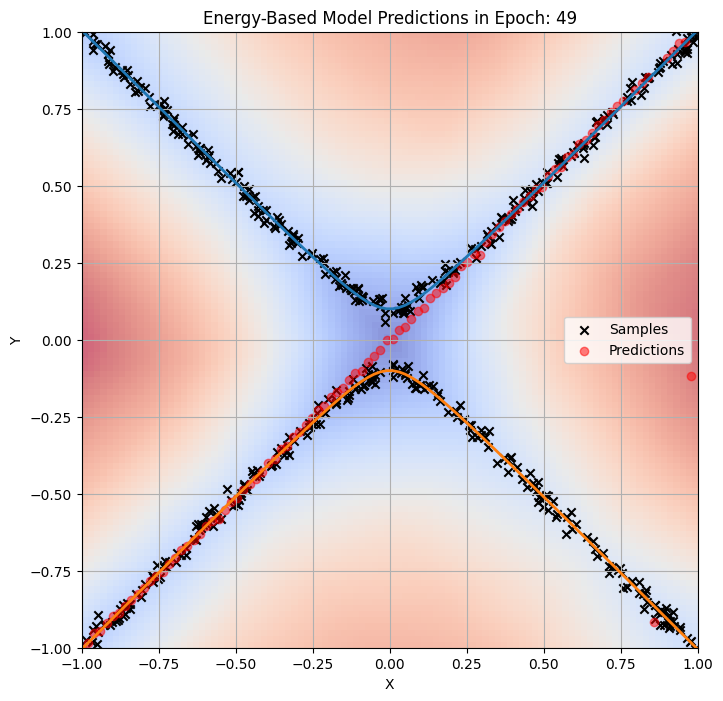

Epoch [51/100], Energy Loss: 4.1564, Generator Loss: -2.0417, Generator Loss (Only G): -2.0417, Gradient Penalty: 0.0000, Diversity: -0.3444, 
Epoch [52/100], Energy Loss: 4.1537, Generator Loss: -2.1199, Generator Loss (Only G): -2.1199, Gradient Penalty: 0.0000, Diversity: -0.3414, 
Epoch [53/100], Energy Loss: 4.1322, Generator Loss: -2.0657, Generator Loss (Only G): -2.0657, Gradient Penalty: 0.0000, Diversity: -0.3277, 
Epoch [54/100], Energy Loss: 4.1331, Generator Loss: -2.1060, Generator Loss (Only G): -2.1060, Gradient Penalty: 0.0000, Diversity: -0.3419, 
Epoch [55/100], Energy Loss: 4.1270, Generator Loss: -2.1416, Generator Loss (Only G): -2.1416, Gradient Penalty: 0.0000, Diversity: -0.3386, 
Epoch [56/100], Energy Loss: 4.1242, Generator Loss: -2.1147, Generator Loss (Only G): -2.1147, Gradient Penalty: 0.0000, Diversity: -0.3339, 
Epoch [57/100], Energy Loss: 4.1241, Generator Loss: -2.1095, Generator Loss (Only G): -2.1095, Gradient Penalty: 0.0000, Diversity: -0.3295, 

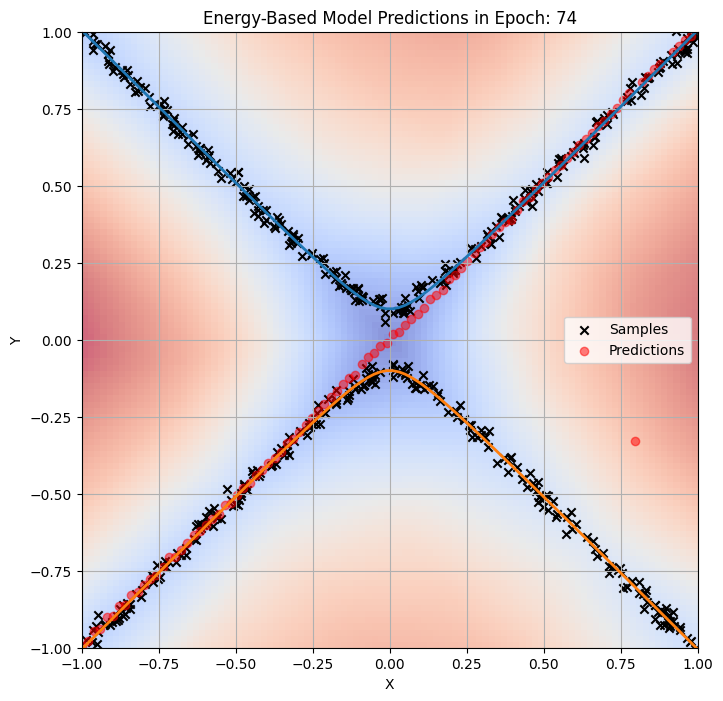

Epoch [76/100], Energy Loss: 4.0751, Generator Loss: -2.3777, Generator Loss (Only G): -2.3777, Gradient Penalty: 0.0000, Diversity: -0.3549, 
Epoch [77/100], Energy Loss: 4.0719, Generator Loss: -2.3364, Generator Loss (Only G): -2.3364, Gradient Penalty: 0.0000, Diversity: -0.3401, 
Epoch [78/100], Energy Loss: 4.0617, Generator Loss: -2.3815, Generator Loss (Only G): -2.3815, Gradient Penalty: 0.0000, Diversity: -0.3481, 
Epoch [79/100], Energy Loss: 4.0525, Generator Loss: -2.4480, Generator Loss (Only G): -2.4480, Gradient Penalty: 0.0000, Diversity: -0.3525, 
Epoch [80/100], Energy Loss: 4.0615, Generator Loss: -2.3969, Generator Loss (Only G): -2.3969, Gradient Penalty: 0.0000, Diversity: -0.3509, 
Epoch [81/100], Energy Loss: 4.0567, Generator Loss: -2.3961, Generator Loss (Only G): -2.3961, Gradient Penalty: 0.0000, Diversity: -0.3492, 
Epoch [82/100], Energy Loss: 4.0623, Generator Loss: -2.3602, Generator Loss (Only G): -2.3602, Gradient Penalty: 0.0000, Diversity: -0.3431, 

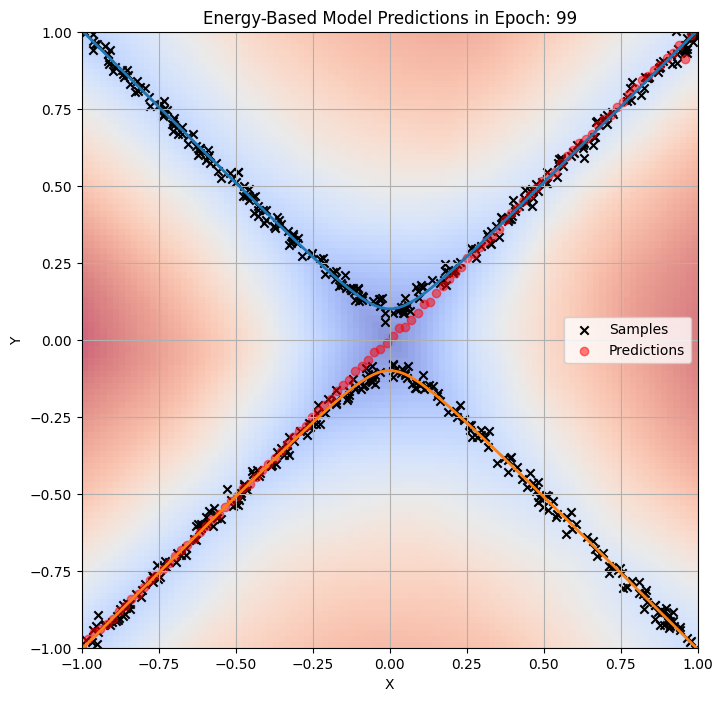

In [94]:
parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size = 64
latent_size = 1
output_size = 1

num_epochs = 100
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

learning_rate_e = 0.001
learning_rate_g = 0.0005
lambda_gp = 0
diversity_weight = 0.00
max_noise_scale = 0.5

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)


import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device, lambda_gp = lambda_gp, diversity_weight = diversity_weight, max_noise_scale = max_noise_scale)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

## Noise may = 0.9

True


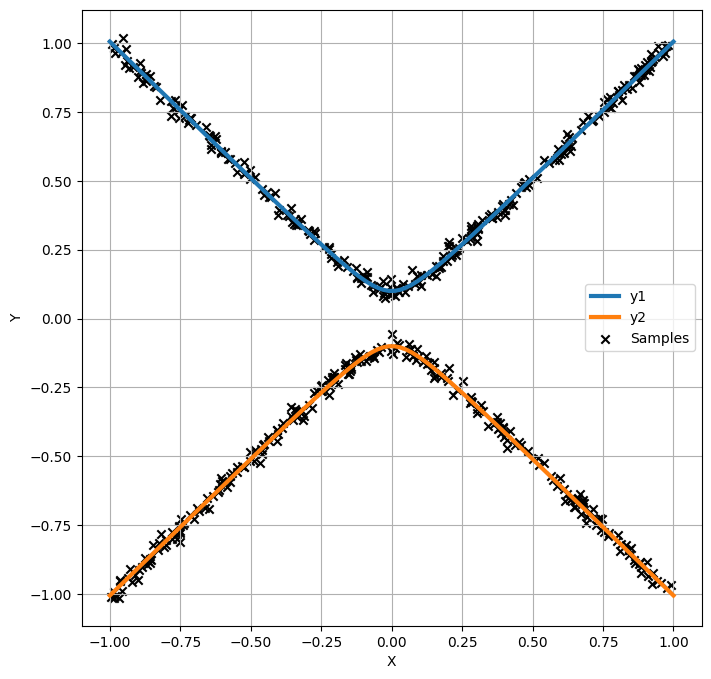

Epoch [1/100], Energy Loss: 5.5475, Generator Loss: 0.0491, Generator Loss (Only G): 0.0492, Gradient Penalty: 0.0000, Diversity: -0.0079, 


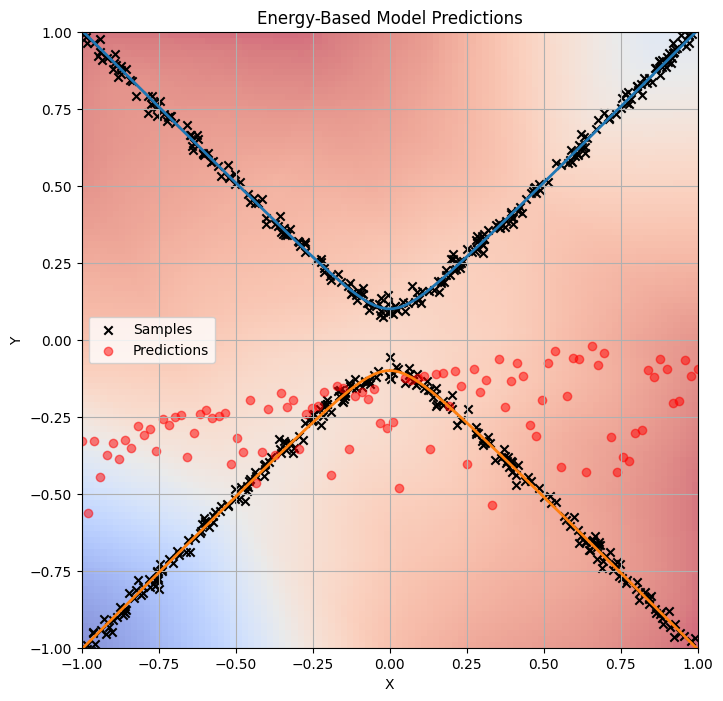

Epoch [2/100], Energy Loss: 5.5318, Generator Loss: 0.0740, Generator Loss (Only G): 0.0744, Gradient Penalty: 0.0000, Diversity: -0.0377, 
Epoch [3/100], Energy Loss: 5.5143, Generator Loss: 0.0549, Generator Loss (Only G): 0.0560, Gradient Penalty: 0.0000, Diversity: -0.1098, 
Epoch [4/100], Energy Loss: 5.4904, Generator Loss: 0.0044, Generator Loss (Only G): 0.0072, Gradient Penalty: 0.0000, Diversity: -0.2778, 
Epoch [5/100], Energy Loss: 5.4627, Generator Loss: -0.0267, Generator Loss (Only G): -0.0220, Gradient Penalty: 0.0000, Diversity: -0.4743, 
Epoch [6/100], Energy Loss: 5.4269, Generator Loss: -0.0333, Generator Loss (Only G): -0.0291, Gradient Penalty: 0.0000, Diversity: -0.4151, 
Epoch [7/100], Energy Loss: 5.3796, Generator Loss: -0.0639, Generator Loss (Only G): -0.0604, Gradient Penalty: 0.0000, Diversity: -0.3525, 
Epoch [8/100], Energy Loss: 5.3280, Generator Loss: -0.0753, Generator Loss (Only G): -0.0717, Gradient Penalty: 0.0000, Diversity: -0.3557, 
Epoch [9/100

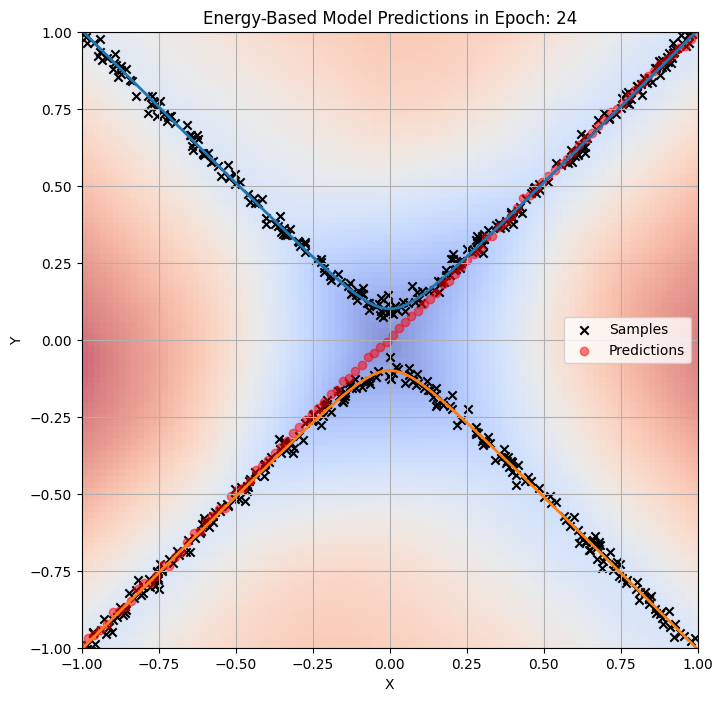

Epoch [26/100], Energy Loss: 4.4459, Generator Loss: -0.2117, Generator Loss (Only G): -0.2083, Gradient Penalty: 0.0000, Diversity: -0.3407, 
Epoch [27/100], Energy Loss: 4.4272, Generator Loss: -0.1847, Generator Loss (Only G): -0.1812, Gradient Penalty: 0.0000, Diversity: -0.3488, 
Epoch [28/100], Energy Loss: 4.3994, Generator Loss: -0.1682, Generator Loss (Only G): -0.1647, Gradient Penalty: 0.0000, Diversity: -0.3500, 
Epoch [29/100], Energy Loss: 4.4023, Generator Loss: -0.1752, Generator Loss (Only G): -0.1718, Gradient Penalty: 0.0000, Diversity: -0.3488, 
Epoch [30/100], Energy Loss: 4.3741, Generator Loss: -0.2276, Generator Loss (Only G): -0.2241, Gradient Penalty: 0.0000, Diversity: -0.3492, 
Epoch [31/100], Energy Loss: 4.3598, Generator Loss: -0.2007, Generator Loss (Only G): -0.1972, Gradient Penalty: 0.0000, Diversity: -0.3518, 
Epoch [32/100], Energy Loss: 4.3568, Generator Loss: -0.1846, Generator Loss (Only G): -0.1810, Gradient Penalty: 0.0000, Diversity: -0.3533, 

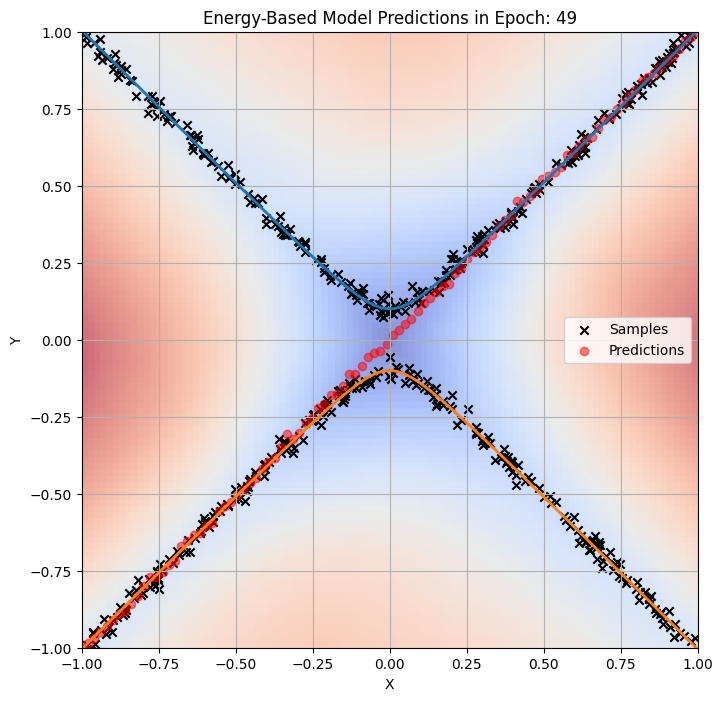

Epoch [51/100], Energy Loss: 4.1871, Generator Loss: -0.0674, Generator Loss (Only G): -0.0639, Gradient Penalty: 0.0000, Diversity: -0.3448, 
Epoch [52/100], Energy Loss: 4.1851, Generator Loss: -0.0879, Generator Loss (Only G): -0.0844, Gradient Penalty: 0.0000, Diversity: -0.3476, 
Epoch [53/100], Energy Loss: 4.1762, Generator Loss: -0.0781, Generator Loss (Only G): -0.0747, Gradient Penalty: 0.0000, Diversity: -0.3464, 
Epoch [54/100], Energy Loss: 4.1757, Generator Loss: -0.0788, Generator Loss (Only G): -0.0753, Gradient Penalty: 0.0000, Diversity: -0.3493, 
Epoch [55/100], Energy Loss: 4.1814, Generator Loss: -0.0368, Generator Loss (Only G): -0.0332, Gradient Penalty: 0.0000, Diversity: -0.3520, 
Epoch [56/100], Energy Loss: 4.1624, Generator Loss: -0.0593, Generator Loss (Only G): -0.0559, Gradient Penalty: 0.0000, Diversity: -0.3396, 
Epoch [57/100], Energy Loss: 4.1654, Generator Loss: -0.0669, Generator Loss (Only G): -0.0635, Gradient Penalty: 0.0000, Diversity: -0.3418, 

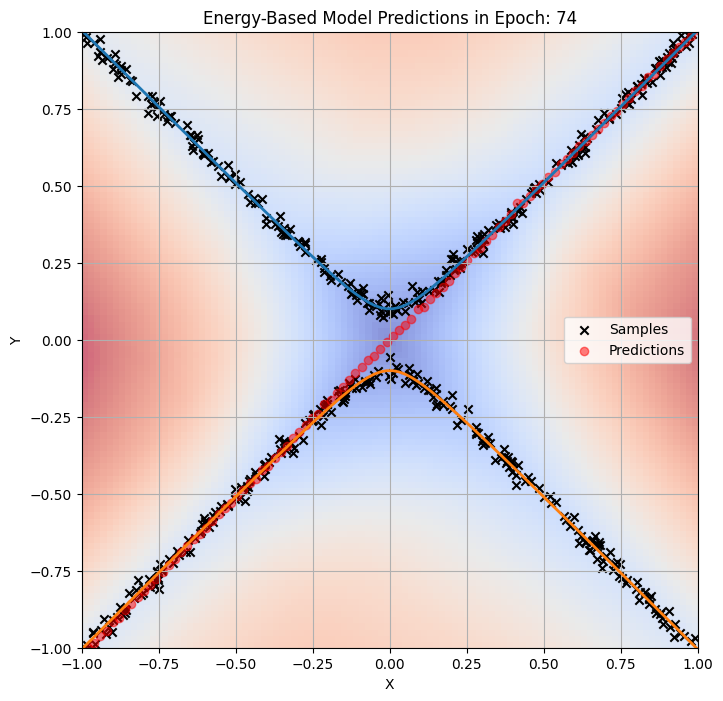

Epoch [76/100], Energy Loss: 4.1062, Generator Loss: -0.0319, Generator Loss (Only G): -0.0284, Gradient Penalty: 0.0000, Diversity: -0.3452, 
Epoch [77/100], Energy Loss: 4.1073, Generator Loss: -0.0225, Generator Loss (Only G): -0.0191, Gradient Penalty: 0.0000, Diversity: -0.3448, 
Epoch [78/100], Energy Loss: 4.1091, Generator Loss: -0.0108, Generator Loss (Only G): -0.0074, Gradient Penalty: 0.0000, Diversity: -0.3447, 
Epoch [79/100], Energy Loss: 4.1030, Generator Loss: -0.0247, Generator Loss (Only G): -0.0212, Gradient Penalty: 0.0000, Diversity: -0.3490, 
Epoch [80/100], Energy Loss: 4.1110, Generator Loss: -0.0406, Generator Loss (Only G): -0.0371, Gradient Penalty: 0.0000, Diversity: -0.3476, 
Epoch [81/100], Energy Loss: 4.1006, Generator Loss: -0.0278, Generator Loss (Only G): -0.0243, Gradient Penalty: 0.0000, Diversity: -0.3474, 
Epoch [82/100], Energy Loss: 4.1002, Generator Loss: -0.0083, Generator Loss (Only G): -0.0048, Gradient Penalty: 0.0000, Diversity: -0.3512, 

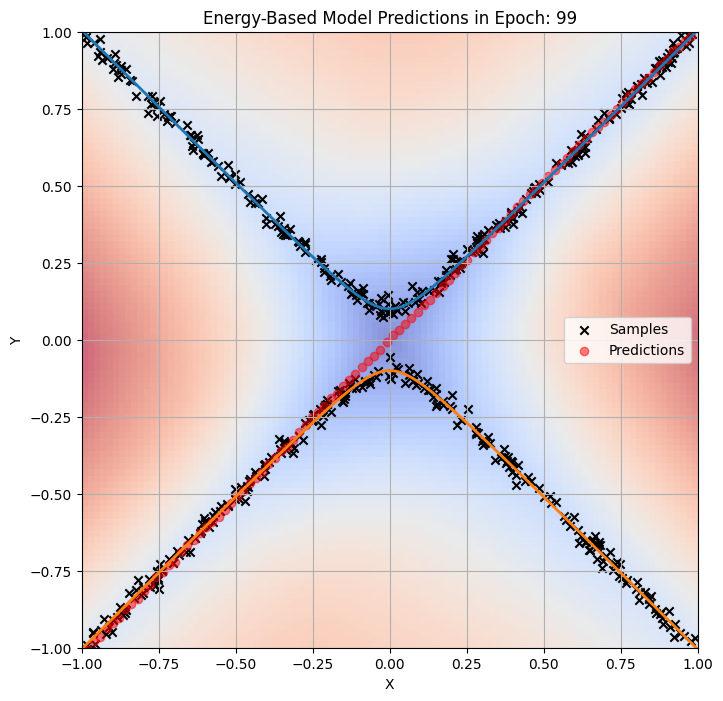

In [96]:
parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size = 64
latent_size = 1
output_size = 1

num_epochs = 100
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

learning_rate_e = 0.001
learning_rate_g = 0.0005
lambda_gp = 0
diversity_weight = 0.01
max_noise_scale = 0.9

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)


import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device, lambda_gp = lambda_gp, diversity_weight = diversity_weight, max_noise_scale = max_noise_scale)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

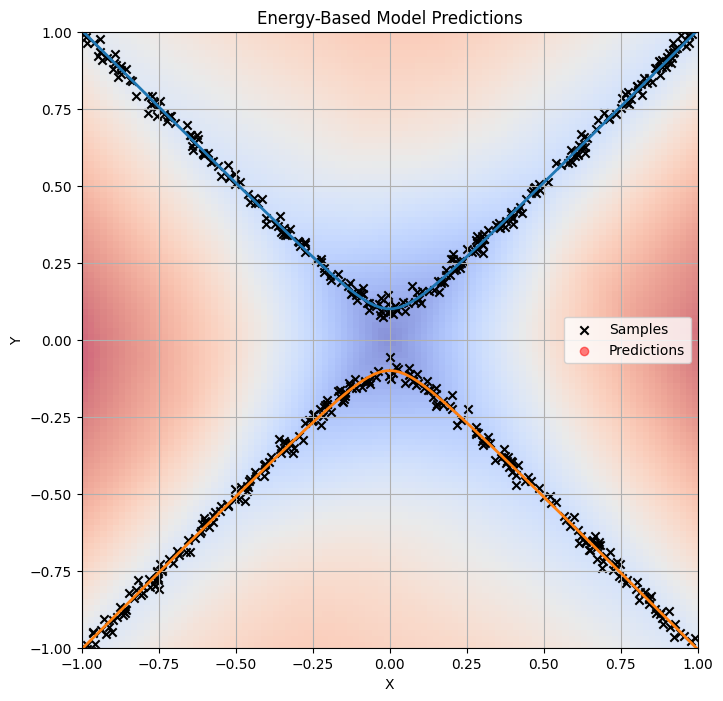

In [ ]:

def visualize_training(generator, energy_model, y_multi, x, y, device, epoch = None, save_path="visualizations", num_query_points = 100):
    # Random sample the query points and get the predictions
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)

    predictions = []
    for point in query_points:
        query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
        z = torch.randn(1, generator.latent_size, device=device) 
        prediction = generator(z, query_points_tensor).detach().cpu().numpy()
        predictions.append(prediction.item())


    # Visualize the energy model output heatmap
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

    # Compute energy model output for each grid point
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
    energy_outputs = energy_outputs.reshape(100, 100)

    # Normalize every column of the heatmap
    # energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))
    # Normalize everything of the heatmap
    energy_outputs = (energy_outputs - energy_outputs.min()) / (energy_outputs.max() - energy_outputs.min())


    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
    # plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

    # Plot the function
    x_vals = np.linspace(-1, 1, 100)
    y_vals = [y_multi(x_i) for x_i in x_vals]
    y_vals_transposed = list(zip(*y_vals))

    for i, y_val in enumerate(y_vals_transposed):
        ax.plot(x_vals, y_val, linewidth=2)

    # Plot the samples and predictions
    ax.scatter(x, y, marker='x', color='black', label='Samples')
    ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid()
    ax.legend()
    if epoch: 
        ax.set_title(f'Energy-Based Model Predictions in Epoch: {epoch + 1}')
    else: 
        ax.set_title('Energy-Based Model Predictions')
    # plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
    plt.show()
    
visualize_training(generator, energy_model, y_multi, x, y, device, epoch = 0, save_path="visualizations", num_query_points = 1)

[0.5173341035842896, 0.5151647329330444, 0.5211449861526489, 0.5148806571960449, 0.517629861831665, 0.5207955837249756, 0.516488790512085, 0.5144442319869995, 0.5162253379821777, 0.5214738845825195, 0.5160858035087585, 0.5175501108169556, 0.5146206021308899, 0.5135584473609924, 0.5134745836257935, 0.5124084949493408, 0.5156439542770386, 0.5173677206039429, 0.517296314239502, 0.5146754384040833, 0.5123337507247925, 0.5159609317779541, 0.5139604210853577, 0.5122302174568176, 0.5212085247039795, 0.5176310539245605, 0.5145969986915588, 0.5172309279441833, 0.5188086032867432, 0.5208983421325684, 0.5157443284988403, 0.5232212543487549, 0.5122133493423462, 0.5211881399154663, 0.5154858231544495, 0.5152721405029297, 0.5153998732566833, 0.516660749912262, 0.5151499509811401, 0.5148025751113892, 0.5172510147094727, 0.5177443027496338, 0.5161935091018677, 0.5163253545761108, 0.5170873403549194, 0.5165770649909973, 0.5142496824264526, 0.5123379230499268, 0.5156501531600952, 0.514878511428833, 0.51

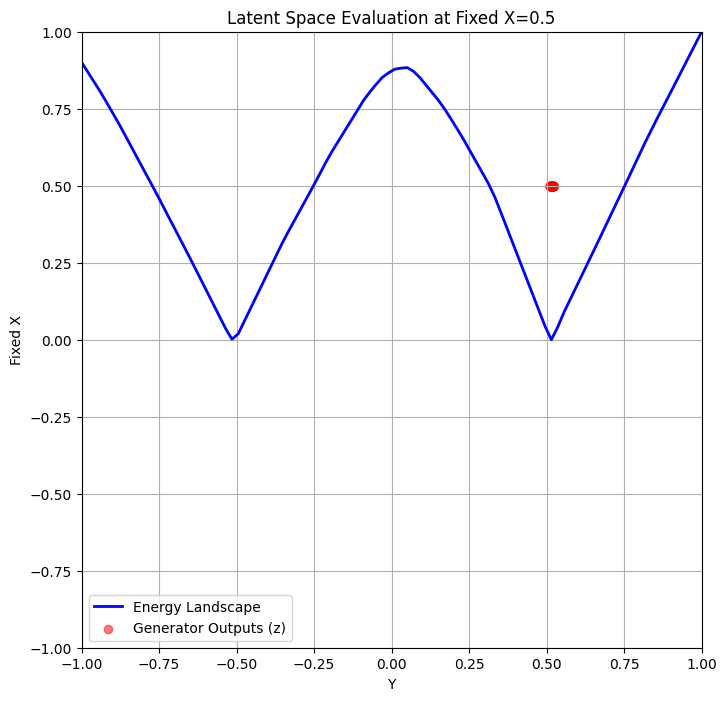

In [109]:
def evaluate_latent_space(generator, energy_model, fixed_x, device, num_latent_samples=100, save_path="visualizations", epoch=None):
    """
    Visualize generator outputs for a fixed condition (x) and varying latent space (z).

    Args:
        generator (nn.Module): The generator model.
        energy_model (nn.Module): The energy model.
        fixed_x (float): The fixed condition value (e.g., a specific x-coordinate).
        device (torch.device): The device (CPU or GPU).
        num_latent_samples (int): Number of latent space samples to evaluate.
        save_path (str): Directory to save visualizations.
        epoch (int, optional): Current epoch for display in the title.
    """
    # Fix the condition and convert to a tensor
    fixed_x_tensor = torch.tensor([[fixed_x]], dtype=torch.float32).to(device)

    # Sample multiple latent vectors z
    z_values = torch.randn(num_latent_samples, generator.latent_size, device=device)
    predictions = []

    # Generate outputs for each latent vector
    for z in z_values:
        pred = generator(z.unsqueeze(0), fixed_x_tensor).detach().cpu().numpy()
        predictions.append(pred.item())

    # Visualize the energy model output heatmap
    y_range = np.linspace(-1, 1, 100)
    grid_y = torch.tensor(y_range, dtype=torch.float32, device=device).unsqueeze(1)
    grid_points = torch.cat([fixed_x_tensor.repeat(len(grid_y), 1), grid_y], dim=1)
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()

    # Normalize the energy model output
    energy_outputs = (energy_outputs - energy_outputs.min()) / (energy_outputs.max() - energy_outputs.min())

    # Plot the results
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the energy model output
    ax.plot(y_range, energy_outputs, color="blue", linewidth=2, label="Energy Landscape")

    # Plot the generator predictions
    print(predictions)
    ax.scatter(predictions, [fixed_x] * len(predictions), color="red", label="Generator Outputs (z)", alpha=0.5)

    # Add labels, legend, and title
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("Y")
    ax.set_ylabel("Fixed X")
    ax.grid()
    ax.legend()
    if epoch:
        ax.set_title(f"Latent Space Evaluation at Fixed X={fixed_x}, Epoch: {epoch + 1}")
    else:
        ax.set_title(f"Latent Space Evaluation at Fixed X={fixed_x}")

    # Show and optionally save the plot
    plt.show()

# Example usage:
evaluate_latent_space(generator, energy_model, fixed_x=0.5, device=device, num_latent_samples=100, epoch=0)


z: (-0.7375606,), y: 0.5128000974655151
z: (-0.3568202,), y: 0.5143446922302246
z: (1.5638729,), y: 0.5178204774856567
z: (-1.7439609,), y: 0.5165281295776367
z: (-0.015127985,), y: 0.5170007348060608
z: (0.98842686,), y: 0.5172936916351318
z: (-0.07220318,), y: 0.5147812366485596
z: (1.0938483,), y: 0.5172715187072754
z: (0.36207244,), y: 0.5158097743988037
z: (-0.19550428,), y: 0.5122302770614624
z: (0.24213047,), y: 0.5152385234832764
z: (-0.5702685,), y: 0.5152010917663574
z: (1.0768512,), y: 0.5173405408859253
z: (-1.576669,), y: 0.5178382396697998
z: (0.42041355,), y: 0.5176938772201538
z: (0.5165309,), y: 0.5202765464782715
z: (-0.48075753,), y: 0.5149270296096802
z: (-0.07134666,), y: 0.5147851705551147
z: (-0.10190553,), y: 0.5146464109420776
z: (-0.29111394,), y: 0.5130393505096436
z: (0.24177146,), y: 0.5152415037155151
z: (0.022295043,), y: 0.5175922513008118
z: (-0.95425075,), y: 0.5149234533309937
z: (0.40424058,), y: 0.5170354843139648
z: (-1.2681763,), y: 0.514271795749

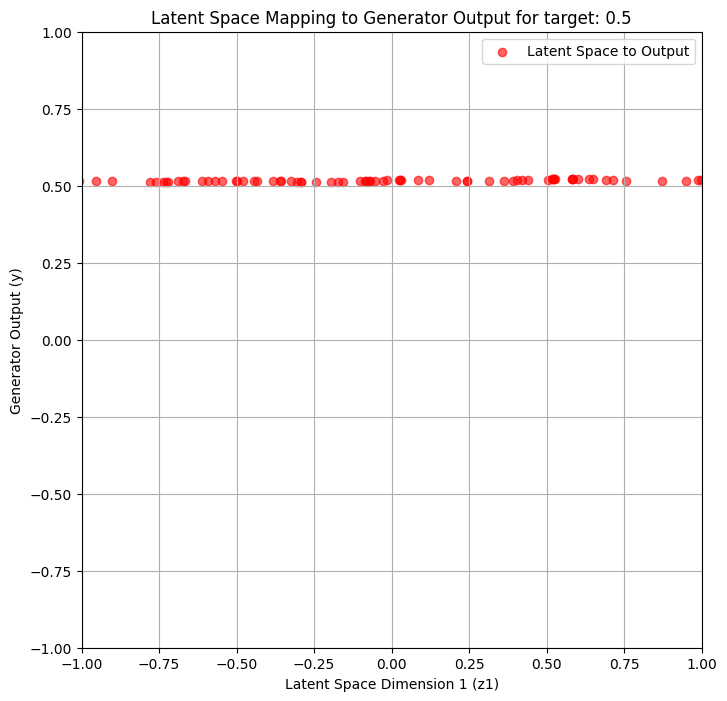

In [114]:
def map_latent_to_outputs(generator, fixed_x, device, num_latent_samples=100):
    """
    Map the latent space values (z) to the generator's outputs (y) for a fixed condition.

    Args:
        generator (nn.Module): The generator model.
        fixed_x (float): The fixed condition value (e.g., a specific x-coordinate).
        device (torch.device): The device (CPU or GPU).
        num_latent_samples (int): Number of latent space samples to evaluate.

    Returns:
        dict: A dictionary mapping latent vectors (z) to outputs (y).
    """
    # Fix the condition and convert to a tensor
    fixed_x_tensor = torch.tensor([[fixed_x]], dtype=torch.float32).to(device)

    # Sample multiple latent vectors z
    z_values = torch.randn(num_latent_samples, generator.latent_size, device=device)
    z_to_y_mapping = {}

    # Generate outputs for each latent vector
    for z in z_values:
        z_numpy = z.detach().cpu().numpy()  # Save latent vector
        pred = generator(z.unsqueeze(0), fixed_x_tensor).detach().cpu().numpy()
        z_to_y_mapping[tuple(z_numpy)] = pred.item()  # Map z -> y

    return z_to_y_mapping

# Example usage:
fixed_x = 0.5
latent_to_output_map = map_latent_to_outputs(generator, fixed_x, device=device, num_latent_samples=100)

# Print the mapping
for z, y in latent_to_output_map.items():
    print(f"z: {z}, y: {y}")

def visualize_latent_space_mapping(latent_to_output_map, fixed_x):
    """
    Visualize the latent space values (z) and their corresponding outputs (y).

    Args:
        latent_to_output_map (dict): Mapping of latent vectors (z) to generator outputs (y).
    """
    # Extract latent space and outputs
    z_values = np.array(list(latent_to_output_map.keys()))
    y_values = np.array(list(latent_to_output_map.values()))

    # Plot latent space to output mapping
    plt.figure(figsize=(8, 8))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.scatter(z_values[:, 0], y_values, c="red", alpha=0.6, label="Latent Space to Output")
    plt.xlabel("Latent Space Dimension 1 (z1)")
    plt.ylabel("Generator Output (y)")
    plt.grid()
    plt.legend()
    plt.title(f"Latent Space Mapping to Generator Output for target: {fixed_x}")
    plt.show()

# Example usage:
visualize_latent_space_mapping(latent_to_output_map, fixed_x)


# Diversity Part 2

True


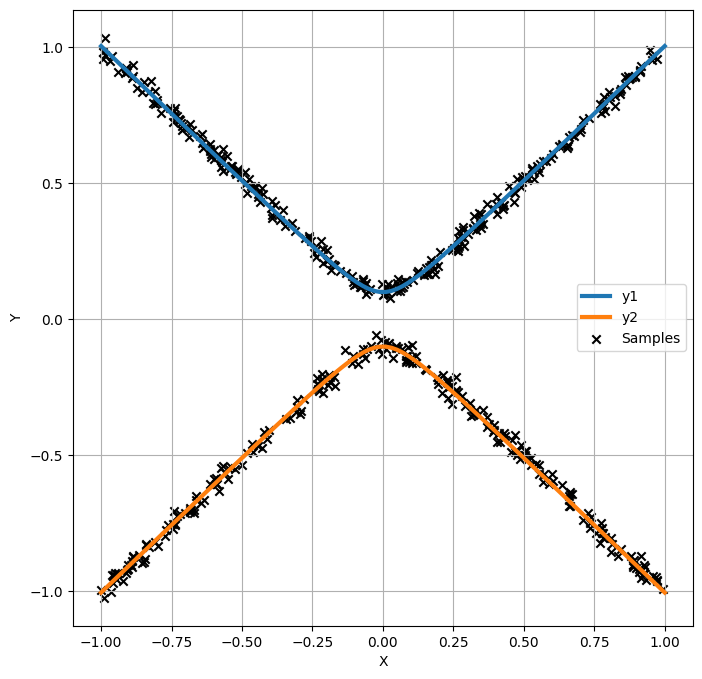

Epoch [1/20], Energy Loss: 5.5425, Generator Loss: -0.0667, Generator Loss (Only G): -0.0577, Gradient Penalty: 0.0000, Diversity: -0.0257, 


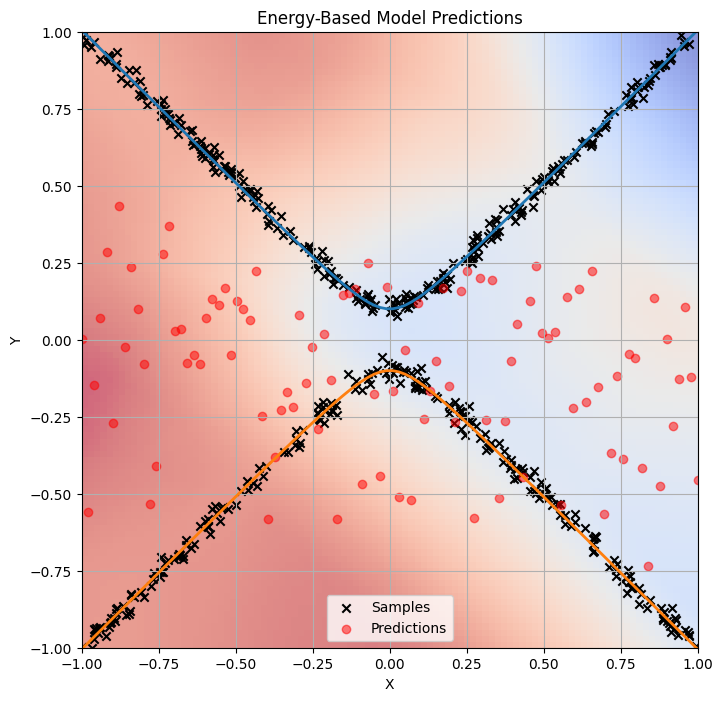

Epoch [2/20], Energy Loss: 5.5221, Generator Loss: -0.1154, Generator Loss (Only G): -0.0938, Gradient Penalty: 0.0000, Diversity: -0.1014, 
Epoch [3/20], Energy Loss: 5.5000, Generator Loss: -0.1796, Generator Loss (Only G): -0.1491, Gradient Penalty: 0.0000, Diversity: -0.1679, 
Epoch [4/20], Energy Loss: 5.4671, Generator Loss: -0.2969, Generator Loss (Only G): -0.2590, Gradient Penalty: 0.0000, Diversity: -0.2487, 
Epoch [5/20], Energy Loss: 5.4257, Generator Loss: -0.4164, Generator Loss (Only G): -0.3515, Gradient Penalty: 0.0000, Diversity: -0.5788, 


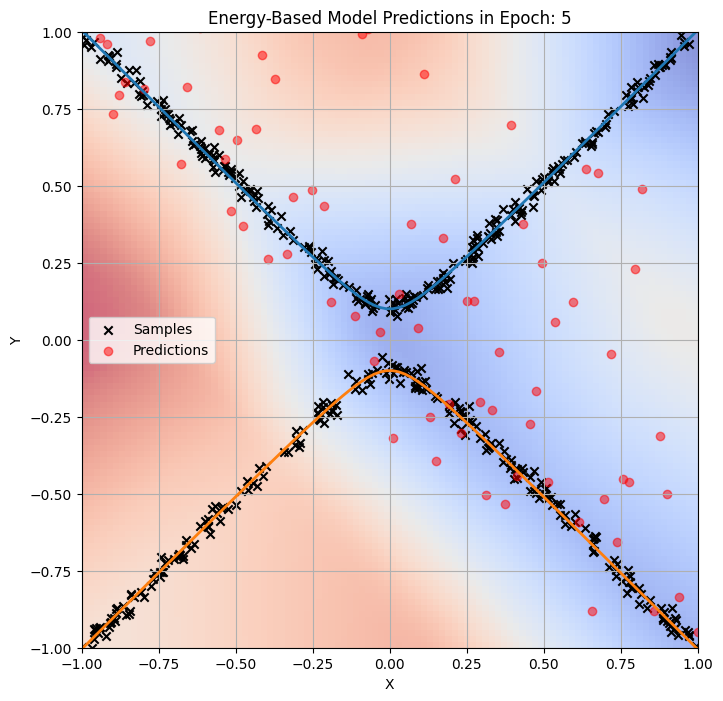

Epoch [6/20], Energy Loss: 5.3787, Generator Loss: -0.6450, Generator Loss (Only G): -0.5455, Gradient Penalty: 0.0000, Diversity: -1.1140, 
Epoch [7/20], Energy Loss: 5.3173, Generator Loss: -0.7682, Generator Loss (Only G): -0.6119, Gradient Penalty: 0.0000, Diversity: -1.9501, 
Epoch [8/20], Energy Loss: 5.2407, Generator Loss: -1.0388, Generator Loss (Only G): -0.8414, Gradient Penalty: 0.0000, Diversity: -2.3990, 
Epoch [9/20], Energy Loss: 5.1620, Generator Loss: -1.1983, Generator Loss (Only G): -0.9076, Gradient Penalty: 0.0000, Diversity: -3.8469, 
Epoch [10/20], Energy Loss: 5.0839, Generator Loss: -1.3740, Generator Loss (Only G): -1.0479, Gradient Penalty: 0.0000, Diversity: -4.6232, 


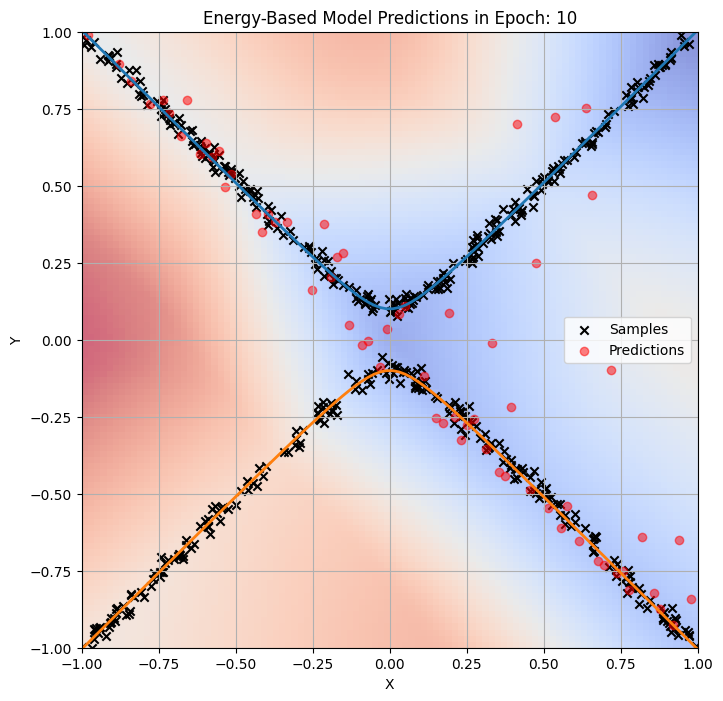

Epoch [11/20], Energy Loss: 5.0059, Generator Loss: -1.4678, Generator Loss (Only G): -1.1511, Gradient Penalty: 0.0000, Diversity: -4.6603, 
Epoch [12/20], Energy Loss: 4.9268, Generator Loss: -1.8795, Generator Loss (Only G): -1.6105, Gradient Penalty: 0.0000, Diversity: -3.6841, 
Epoch [13/20], Energy Loss: 4.8524, Generator Loss: -2.0596, Generator Loss (Only G): -1.8533, Gradient Penalty: 0.0000, Diversity: -2.8115, 
Epoch [14/20], Energy Loss: 4.7875, Generator Loss: -2.6696, Generator Loss (Only G): -2.5332, Gradient Penalty: 0.0000, Diversity: -1.6327, 
Epoch [15/20], Energy Loss: 4.7288, Generator Loss: -2.7650, Generator Loss (Only G): -2.6903, Gradient Penalty: 0.0000, Diversity: -0.9742, 


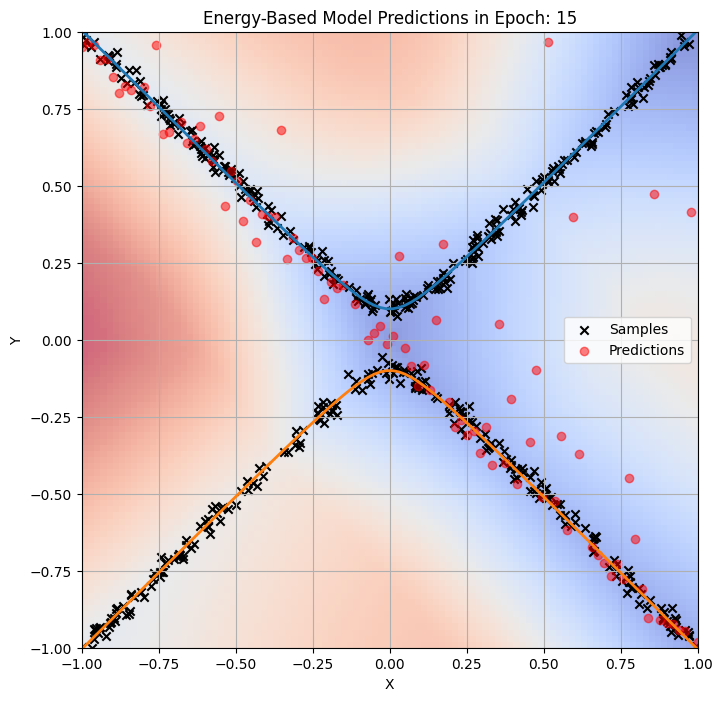

Epoch [16/20], Energy Loss: 4.6627, Generator Loss: -3.4134, Generator Loss (Only G): -3.3702, Gradient Penalty: 0.0000, Diversity: -0.5161, 
Epoch [17/20], Energy Loss: 4.6013, Generator Loss: -3.8538, Generator Loss (Only G): -3.8266, Gradient Penalty: 0.0000, Diversity: -0.3843, 
Epoch [18/20], Energy Loss: 4.5580, Generator Loss: -4.2334, Generator Loss (Only G): -4.2115, Gradient Penalty: 0.0000, Diversity: -0.3478, 
Epoch [19/20], Energy Loss: 4.5127, Generator Loss: -4.5593, Generator Loss (Only G): -4.5398, Gradient Penalty: 0.0000, Diversity: -0.3397, 
Epoch [20/20], Energy Loss: 4.4690, Generator Loss: -4.8178, Generator Loss (Only G): -4.7990, Gradient Penalty: 0.0000, Diversity: -0.3429, 


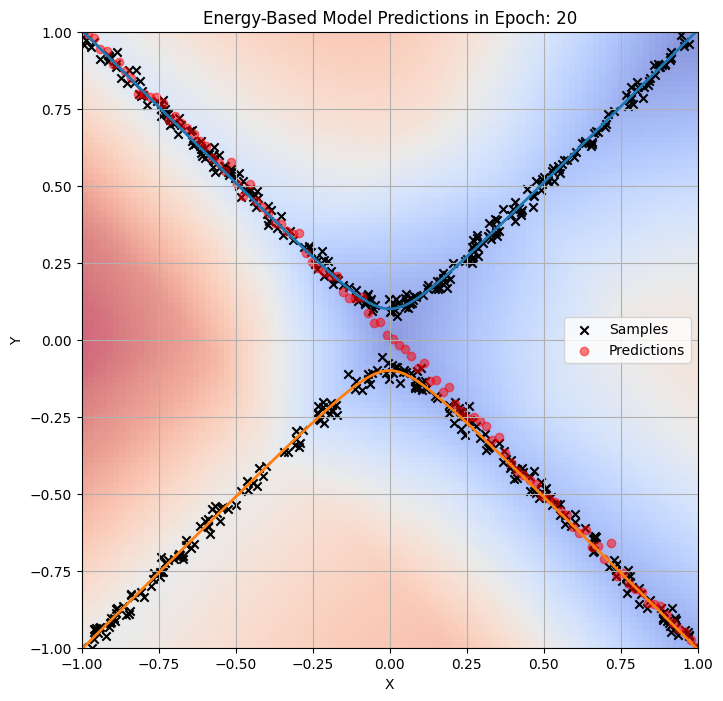

In [123]:
# EBGAN-BC  Code

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset

# Energy-based Model
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, action_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y) # condition, data
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    return [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min 
            for _ in range(neg_count)]
    
def compute_gradient_penalty(energy_model, condition, real_samples, fake_samples, device, lambda_gp=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    Args:
        energy_model (nn.Module): The energy-based model.
        condition (Tensor): The condition on which the model is build on.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        device (torch.device): The device (CPU or GPU).
        lambda_gp (float): Coefficient for the gradient penalty.

    Returns:
        Tensor: The gradient penalty term.
    """
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)  # Match dimensions
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute energy model output for interpolated samples
    interpolated_energy = energy_model(condition, interpolated)

    # Compute gradients of energy model output with respect to interpolated samples
    gradients = torch.autograd.grad(
        outputs=interpolated_energy,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_energy, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute L2 norm of gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Gradient penalty term
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

# Training function
def train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, 
          num_epochs, writer, y_min, y_max, neg_count, repeat_energy_updates, device, lambda_gp = 10, diversity_weight = 0.1, max_noise_scale = 0.1, eval_image_time = 25):
    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss = 0.0
        epoch_g_loss_i = 0.0
        epoch_g_penalty = 0.0
        epoch_diversity = 0.0
        i = 0
        noise_scale = max(max_noise_scale, 1 - epoch / num_epochs) if max_noise_scale > 0 else 0
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.float().to(device) # conditon
            y_target = batch_y.float().to(device) # real data
            
            # Update energy model
            for _ in range(repeat_energy_updates):
                # Generate counter samples
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Add generator samples to counter samples
                z = torch.randn(x_input.size(0), generator.latent_size, device=device) * noise_scale

                with torch.no_grad():
                    fake_y = generator(z, x_input) # fake data
                counter_samples.append(fake_y)
                
                # Compute energy model loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples)
                
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()
            
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size, device=device)
            
            fake_y = generator(z, x_input)
            g_loss = torch.mean(energy_model(x_input, fake_y))
            epoch_g_loss_i += g_loss.item()
            
            # Add gradient penalty
            gradient_penalty = compute_gradient_penalty(energy_model, x_input, y_target, fake_y, device, lambda_gp)
            # g_loss += gradient_penalty
            
            # Add diversity loss
            z1, z2 = torch.randn(x_input.size(0), generator.latent_size, device=device), torch.randn(x_input.size(0), generator.latent_size, device=device)
            fake_y1, fake_y2 = generator(z1, x_input), generator(z2, x_input)
            diversity_loss = -torch.mean(torch.norm(fake_y1 - fake_y2, dim=-1))
            g_loss += diversity_weight * diversity_loss

            diversity_loss = -torch.var(generator(z, x_input), dim=0).mean()
            g_loss += diversity_weight * diversity_loss
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_g_loss += g_loss.item()
            epoch_g_penalty += gradient_penalty.item()
            epoch_diversity += diversity_loss.item()
            
            # Log losses
            writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)
            i+=1
        
        scheduler_e.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_g_loss_i = epoch_g_loss_i / len(dataloader)
        avg_g_pen = epoch_g_penalty / len(dataloader)
        avg_div = epoch_diversity / len(dataloader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Energy Loss: {avg_e_loss:.4f}, "
              f"Generator Loss: {avg_g_loss:.4f}, "
              f"Generator Loss (Only G): {avg_g_loss_i:.4f}, "
              f"Gradient Penalty: {avg_g_pen:.4f}, "
              f"Diversity: {avg_div:.4f}, ")
        
        if (epoch + 1 == 1) or (epoch + 1) %eval_image_time == 0: 
            visualize_training(generator, energy_model, y_multi, x, y, device, epoch, save_path="visualizations")


parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size = 64
latent_size = 1
output_size = 1

num_epochs = 20
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

eval_image_time = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005
lambda_gp = 0
diversity_weight = 0.05
max_noise_scale = 1

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)


import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device, lambda_gp = lambda_gp, diversity_weight = diversity_weight, max_noise_scale = max_noise_scale, eval_image_time = eval_image_time)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

# Model architecture

True


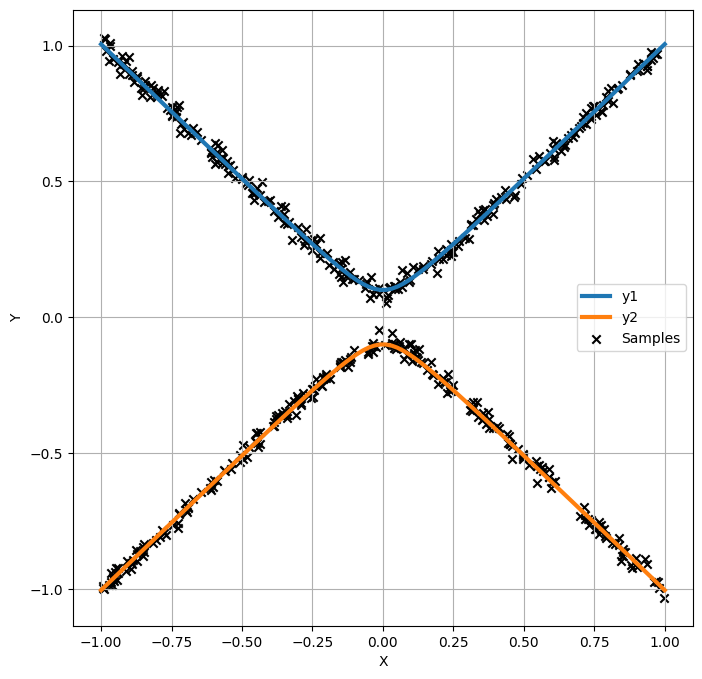

Epoch [1/20], Energy Loss: 5.5429, Generator Loss: -0.0231, Generator Loss (Only G): -0.0213, Gradient Penalty: 0.0000, Diversity: -0.0336, 


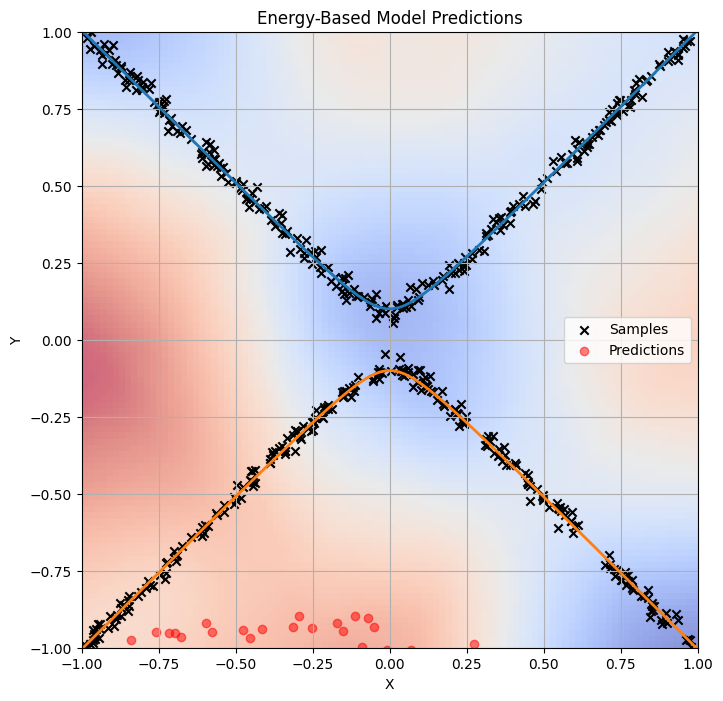

Epoch [2/20], Energy Loss: 5.5226, Generator Loss: 0.0806, Generator Loss (Only G): 0.0861, Gradient Penalty: 0.0000, Diversity: -0.1591, 
Epoch [3/20], Energy Loss: 5.5023, Generator Loss: 0.0286, Generator Loss (Only G): 0.0375, Gradient Penalty: 0.0000, Diversity: -0.3235, 
Epoch [4/20], Energy Loss: 5.4832, Generator Loss: -0.0496, Generator Loss (Only G): -0.0409, Gradient Penalty: 0.0000, Diversity: -0.3223, 
Epoch [5/20], Energy Loss: 5.4641, Generator Loss: -0.1212, Generator Loss (Only G): -0.1171, Gradient Penalty: 0.0000, Diversity: -0.1695, 


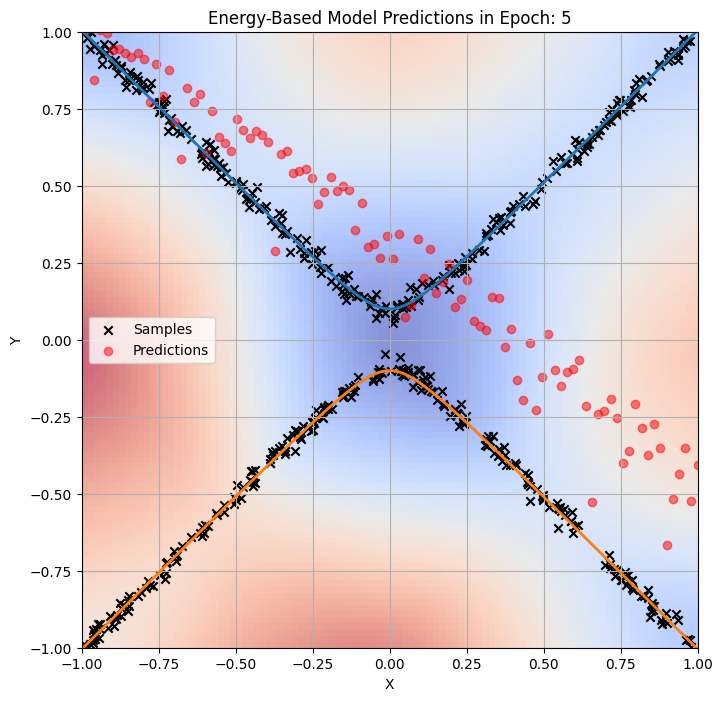

Epoch [6/20], Energy Loss: 5.4404, Generator Loss: -0.1920, Generator Loss (Only G): -0.1877, Gradient Penalty: 0.0000, Diversity: -0.3492, 
Epoch [7/20], Energy Loss: 5.4162, Generator Loss: -0.2440, Generator Loss (Only G): -0.2387, Gradient Penalty: 0.0000, Diversity: -0.4821, 
Epoch [8/20], Energy Loss: 5.3908, Generator Loss: -0.2973, Generator Loss (Only G): -0.2931, Gradient Penalty: 0.0000, Diversity: -0.3751, 
Epoch [9/20], Energy Loss: 5.3655, Generator Loss: -0.3605, Generator Loss (Only G): -0.3563, Gradient Penalty: 0.0000, Diversity: -0.3937, 
Epoch [10/20], Energy Loss: 5.3355, Generator Loss: -0.4224, Generator Loss (Only G): -0.4182, Gradient Penalty: 0.0000, Diversity: -0.3874, 


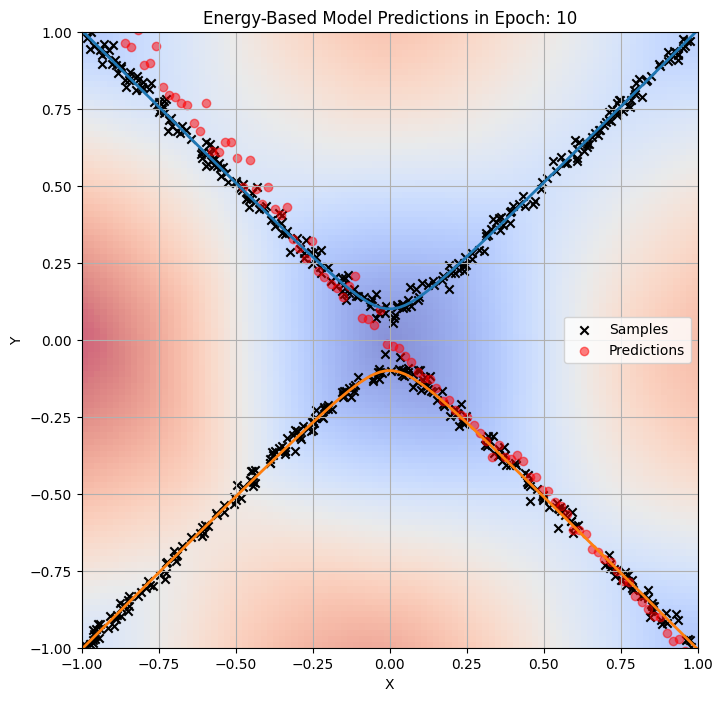

Epoch [11/20], Energy Loss: 5.3064, Generator Loss: -0.4736, Generator Loss (Only G): -0.4695, Gradient Penalty: 0.0000, Diversity: -0.3868, 
Epoch [12/20], Energy Loss: 5.2766, Generator Loss: -0.5183, Generator Loss (Only G): -0.5142, Gradient Penalty: 0.0000, Diversity: -0.3850, 
Epoch [13/20], Energy Loss: 5.2415, Generator Loss: -0.6060, Generator Loss (Only G): -0.6019, Gradient Penalty: 0.0000, Diversity: -0.3962, 
Epoch [14/20], Energy Loss: 5.2121, Generator Loss: -0.6845, Generator Loss (Only G): -0.6805, Gradient Penalty: 0.0000, Diversity: -0.3861, 
Epoch [15/20], Energy Loss: 5.1755, Generator Loss: -0.7451, Generator Loss (Only G): -0.7410, Gradient Penalty: 0.0000, Diversity: -0.3981, 


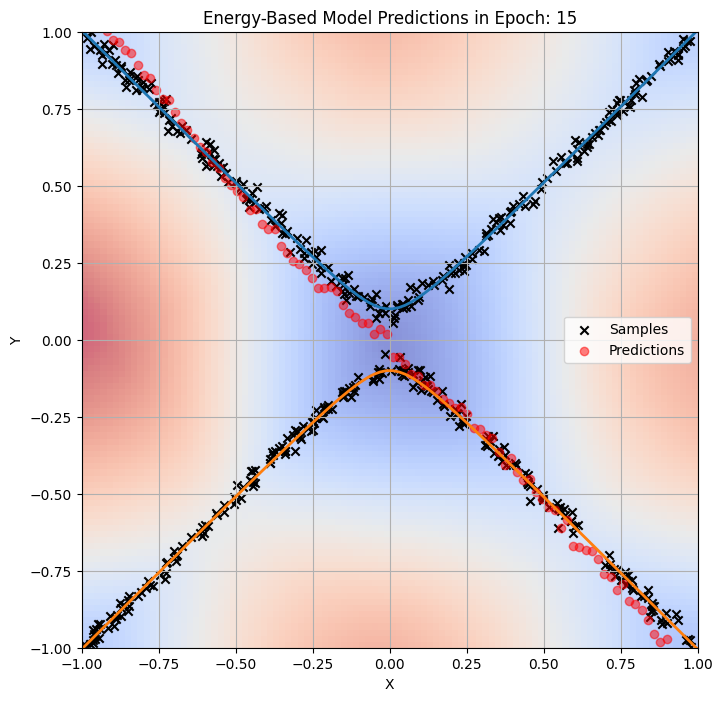

Epoch [16/20], Energy Loss: 5.1393, Generator Loss: -0.8213, Generator Loss (Only G): -0.8171, Gradient Penalty: 0.0000, Diversity: -0.4003, 
Epoch [17/20], Energy Loss: 5.1097, Generator Loss: -0.9098, Generator Loss (Only G): -0.9057, Gradient Penalty: 0.0000, Diversity: -0.3982, 
Epoch [18/20], Energy Loss: 5.0765, Generator Loss: -0.9811, Generator Loss (Only G): -0.9770, Gradient Penalty: 0.0000, Diversity: -0.3876, 
Epoch [19/20], Energy Loss: 5.0437, Generator Loss: -1.0744, Generator Loss (Only G): -1.0703, Gradient Penalty: 0.0000, Diversity: -0.3928, 
Epoch [20/20], Energy Loss: 5.0078, Generator Loss: -1.1239, Generator Loss (Only G): -1.1197, Gradient Penalty: 0.0000, Diversity: -0.4058, 


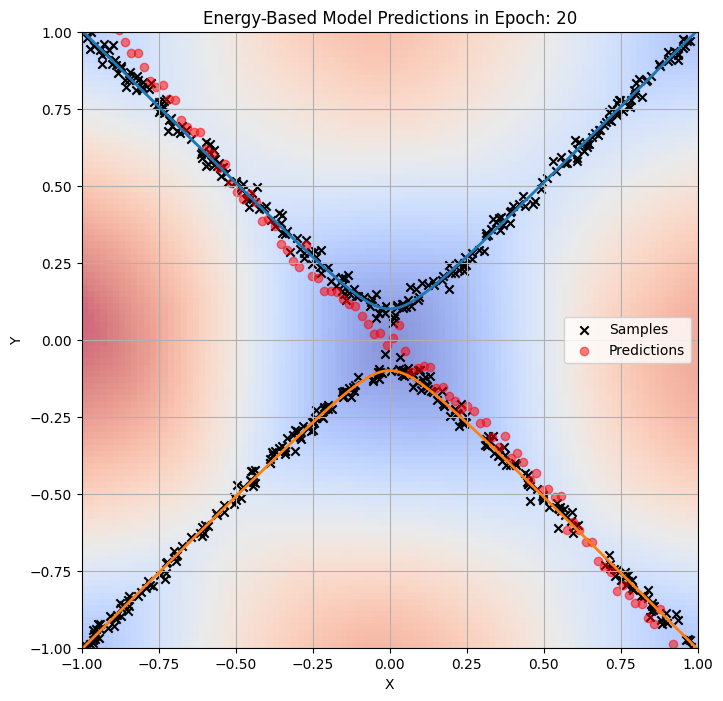

In [126]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset

# Energy-based Model
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        # self.energy_net = nn.Sequential(
        #     nn.Linear(input_size + action_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, 1)
        # )
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, action_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size + condition_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            # nn.Linear(hidden_size, hidden_size),
            # nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, action_size)
        )

        

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y) # condition, data
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    return [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min 
            for _ in range(neg_count)]
    
def compute_gradient_penalty(energy_model, condition, real_samples, fake_samples, device, lambda_gp=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    Args:
        energy_model (nn.Module): The energy-based model.
        condition (Tensor): The condition on which the model is build on.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        device (torch.device): The device (CPU or GPU).
        lambda_gp (float): Coefficient for the gradient penalty.

    Returns:
        Tensor: The gradient penalty term.
    """
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)  # Match dimensions
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute energy model output for interpolated samples
    interpolated_energy = energy_model(condition, interpolated)

    # Compute gradients of energy model output with respect to interpolated samples
    gradients = torch.autograd.grad(
        outputs=interpolated_energy,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_energy, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute L2 norm of gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Gradient penalty term
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

# Training function
def train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, 
          num_epochs, writer, y_min, y_max, neg_count, repeat_energy_updates, device, lambda_gp = 10, diversity_weight = 0.1, max_noise_scale = 0.1, eval_image_time = 25):
    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss = 0.0
        epoch_g_loss_i = 0.0
        epoch_g_penalty = 0.0
        epoch_diversity = 0.0
        i = 0
        noise_scale = max(max_noise_scale, 1 - epoch / num_epochs) if max_noise_scale > 0 else 0
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.float().to(device) # conditon
            y_target = batch_y.float().to(device) # real data
            
            # Update energy model
            for _ in range(repeat_energy_updates):
                # Generate counter samples
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Add generator samples to counter samples
                z = torch.randn(x_input.size(0), generator.latent_size, device=device) * noise_scale

                with torch.no_grad():
                    fake_y = generator(z, x_input) # fake data
                counter_samples.append(fake_y)
                
                # Compute energy model loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples)
                
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()
            
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size, device=device)
            
            fake_y = generator(z, x_input)
            g_loss = torch.mean(energy_model(x_input, fake_y))
            epoch_g_loss_i += g_loss.item()
            
            # Add gradient penalty
            gradient_penalty = compute_gradient_penalty(energy_model, x_input, y_target, fake_y, device, lambda_gp)
            # g_loss += gradient_penalty
            
            # Add diversity loss
            z1, z2 = torch.randn(x_input.size(0), generator.latent_size, device=device), torch.randn(x_input.size(0), generator.latent_size, device=device)
            fake_y1, fake_y2 = generator(z1, x_input), generator(z2, x_input)
            diversity_loss = -torch.mean(torch.norm(fake_y1 - fake_y2, dim=-1))
            g_loss += diversity_weight * diversity_loss

            diversity_loss = -torch.var(generator(z, x_input), dim=0).mean()
            g_loss += diversity_weight * diversity_loss
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_g_loss += g_loss.item()
            epoch_g_penalty += gradient_penalty.item()
            epoch_diversity += diversity_loss.item()
            
            # Log losses
            writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)
            i+=1
        
        scheduler_e.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_g_loss_i = epoch_g_loss_i / len(dataloader)
        avg_g_pen = epoch_g_penalty / len(dataloader)
        avg_div = epoch_diversity / len(dataloader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Energy Loss: {avg_e_loss:.4f}, "
              f"Generator Loss: {avg_g_loss:.4f}, "
              f"Generator Loss (Only G): {avg_g_loss_i:.4f}, "
              f"Gradient Penalty: {avg_g_pen:.4f}, "
              f"Diversity: {avg_div:.4f}, ")
        
        if (epoch + 1 == 1) or (epoch + 1) %eval_image_time == 0: 
            visualize_training(generator, energy_model, y_multi, x, y, device, epoch, save_path="visualizations")


parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size_e = 400
hidden_size_g = 500
latent_size = 1
output_size = 1

num_epochs = 20
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

eval_image_time = 5

learning_rate_e = 0.0001 # 0.001
learning_rate_g = 0.0005
lambda_gp = 0
diversity_weight = 0.01
max_noise_scale = 1

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size_g, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size_e).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)


import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device, lambda_gp = lambda_gp, diversity_weight = diversity_weight, max_noise_scale = max_noise_scale, eval_image_time = eval_image_time)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

True


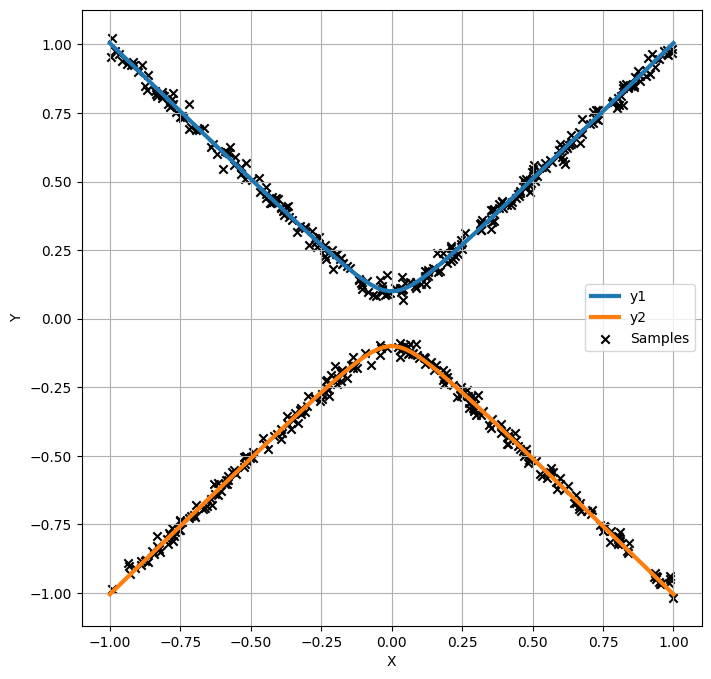

Epoch [1/20], Energy Loss: 5.5370, Generator Loss: 0.0832, Generator Loss (Only G): 0.0832, Gradient Penalty: 0.0000, Diversity: -0.0124, 


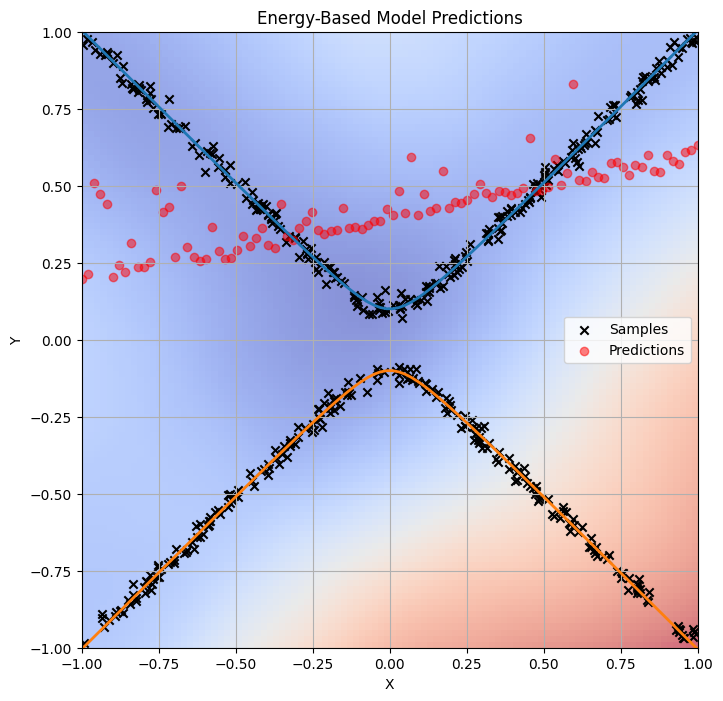

Epoch [2/20], Energy Loss: 5.5149, Generator Loss: 0.0605, Generator Loss (Only G): 0.0605, Gradient Penalty: 0.0000, Diversity: -0.0268, 
Epoch [3/20], Energy Loss: 5.4974, Generator Loss: 0.0430, Generator Loss (Only G): 0.0430, Gradient Penalty: 0.0000, Diversity: -0.0766, 
Epoch [4/20], Energy Loss: 5.4796, Generator Loss: 0.0112, Generator Loss (Only G): 0.0112, Gradient Penalty: 0.0000, Diversity: -0.2641, 
Epoch [5/20], Energy Loss: 5.4604, Generator Loss: 0.0001, Generator Loss (Only G): 0.0001, Gradient Penalty: 0.0000, Diversity: -0.3227, 


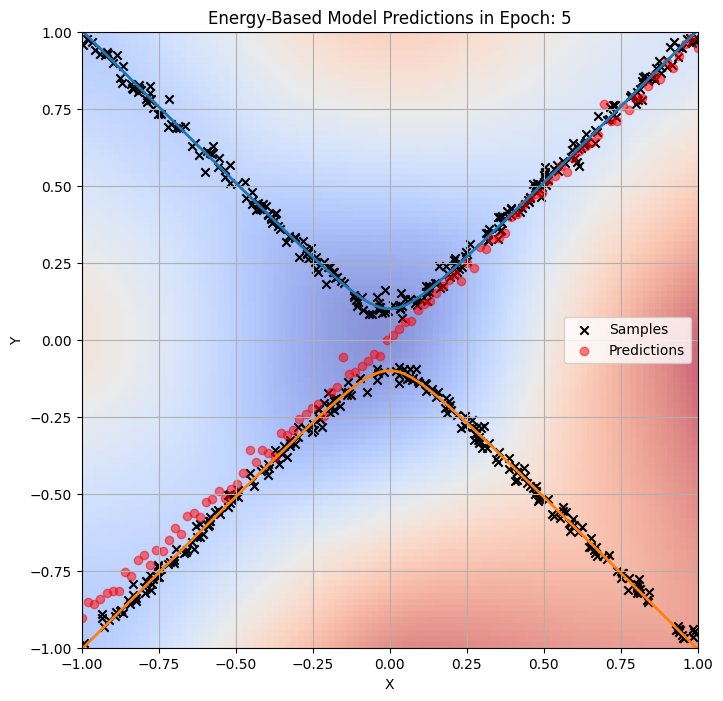

Epoch [6/20], Energy Loss: 5.4407, Generator Loss: -0.0355, Generator Loss (Only G): -0.0355, Gradient Penalty: 0.0000, Diversity: -0.3160, 
Epoch [7/20], Energy Loss: 5.4183, Generator Loss: -0.0558, Generator Loss (Only G): -0.0558, Gradient Penalty: 0.0000, Diversity: -0.3057, 
Epoch [8/20], Energy Loss: 5.3963, Generator Loss: -0.0578, Generator Loss (Only G): -0.0578, Gradient Penalty: 0.0000, Diversity: -0.3240, 
Epoch [9/20], Energy Loss: 5.3710, Generator Loss: -0.0868, Generator Loss (Only G): -0.0868, Gradient Penalty: 0.0000, Diversity: -0.3165, 
Epoch [10/20], Energy Loss: 5.3467, Generator Loss: -0.0758, Generator Loss (Only G): -0.0758, Gradient Penalty: 0.0000, Diversity: -0.3229, 


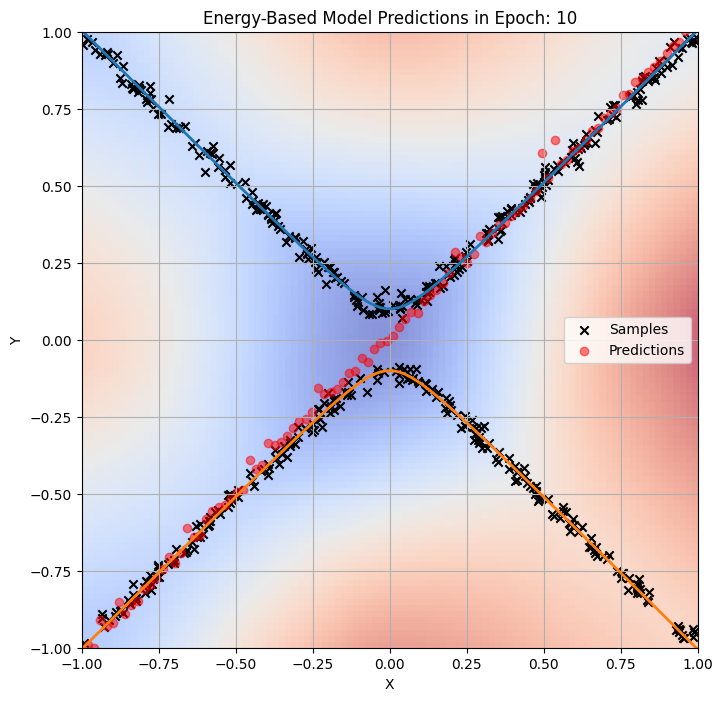

Epoch [11/20], Energy Loss: 5.3156, Generator Loss: -0.1065, Generator Loss (Only G): -0.1065, Gradient Penalty: 0.0000, Diversity: -0.3191, 
Epoch [12/20], Energy Loss: 5.2889, Generator Loss: -0.1049, Generator Loss (Only G): -0.1049, Gradient Penalty: 0.0000, Diversity: -0.3258, 
Epoch [13/20], Energy Loss: 5.2599, Generator Loss: -0.1410, Generator Loss (Only G): -0.1410, Gradient Penalty: 0.0000, Diversity: -0.3231, 
Epoch [14/20], Energy Loss: 5.2259, Generator Loss: -0.1517, Generator Loss (Only G): -0.1517, Gradient Penalty: 0.0000, Diversity: -0.3153, 
Epoch [15/20], Energy Loss: 5.1942, Generator Loss: -0.2024, Generator Loss (Only G): -0.2024, Gradient Penalty: 0.0000, Diversity: -0.3268, 


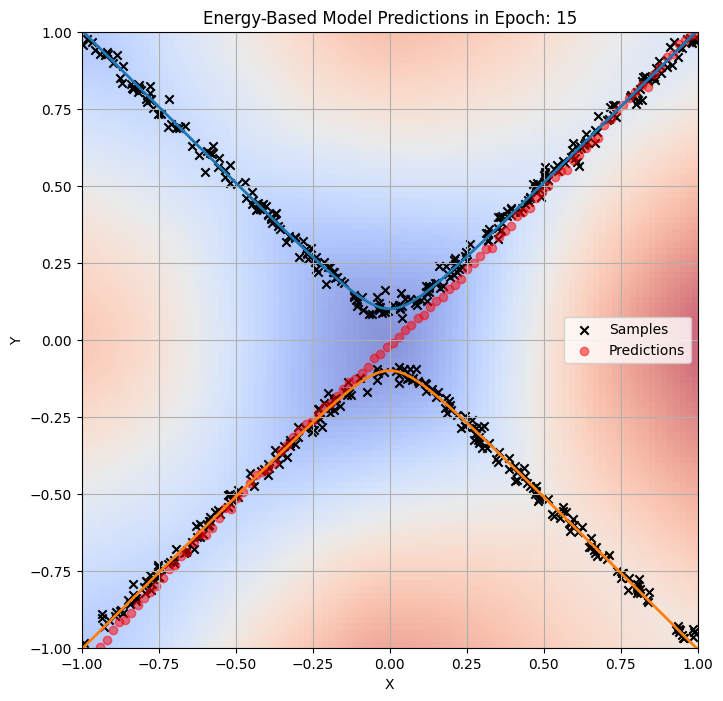

Epoch [16/20], Energy Loss: 5.1622, Generator Loss: -0.2560, Generator Loss (Only G): -0.2560, Gradient Penalty: 0.0000, Diversity: -0.3175, 
Epoch [17/20], Energy Loss: 5.1322, Generator Loss: -0.2993, Generator Loss (Only G): -0.2993, Gradient Penalty: 0.0000, Diversity: -0.3193, 
Epoch [18/20], Energy Loss: 5.1004, Generator Loss: -0.3226, Generator Loss (Only G): -0.3226, Gradient Penalty: 0.0000, Diversity: -0.3292, 
Epoch [19/20], Energy Loss: 5.0674, Generator Loss: -0.3713, Generator Loss (Only G): -0.3713, Gradient Penalty: 0.0000, Diversity: -0.3277, 
Epoch [20/20], Energy Loss: 5.0366, Generator Loss: -0.3980, Generator Loss (Only G): -0.3980, Gradient Penalty: 0.0000, Diversity: -0.3303, 


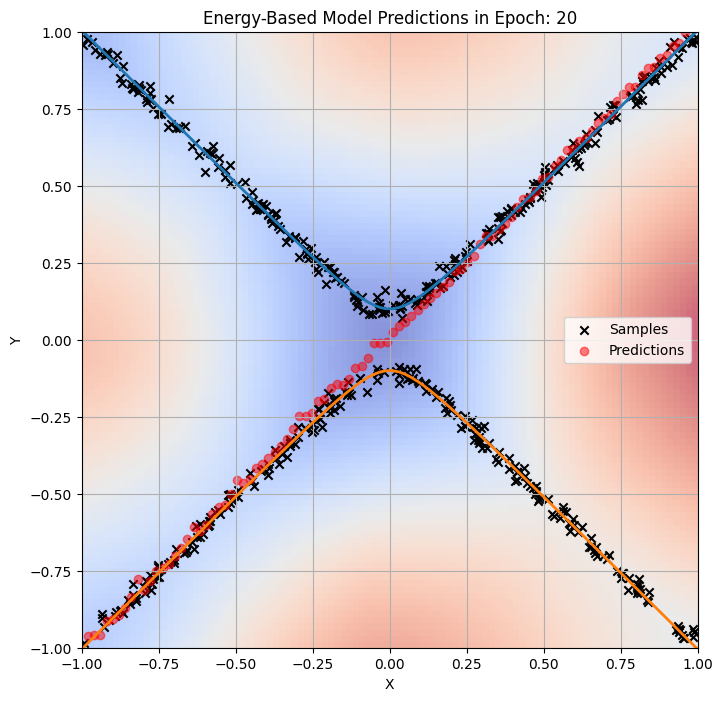

In [127]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset

# Energy-based Model
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        # self.energy_net = nn.Sequential(
        #     nn.Linear(input_size + action_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, 1)
        # )
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, action_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size + condition_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            # nn.Linear(hidden_size, hidden_size),
            # nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, action_size)
        )

        

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y) # condition, data
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    return [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min 
            for _ in range(neg_count)]
    
def compute_gradient_penalty(energy_model, condition, real_samples, fake_samples, device, lambda_gp=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    Args:
        energy_model (nn.Module): The energy-based model.
        condition (Tensor): The condition on which the model is build on.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        device (torch.device): The device (CPU or GPU).
        lambda_gp (float): Coefficient for the gradient penalty.

    Returns:
        Tensor: The gradient penalty term.
    """
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)  # Match dimensions
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute energy model output for interpolated samples
    interpolated_energy = energy_model(condition, interpolated)

    # Compute gradients of energy model output with respect to interpolated samples
    gradients = torch.autograd.grad(
        outputs=interpolated_energy,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_energy, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute L2 norm of gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Gradient penalty term
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

# Training function
def train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, 
          num_epochs, writer, y_min, y_max, neg_count, repeat_energy_updates, device, lambda_gp = 10, diversity_weight = 0.1, max_noise_scale = 0.1, eval_image_time = 25):
    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss = 0.0
        epoch_g_loss_i = 0.0
        epoch_g_penalty = 0.0
        epoch_diversity = 0.0
        i = 0
        noise_scale = max(max_noise_scale, 1 - epoch / num_epochs) if max_noise_scale > 0 else 0
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.float().to(device) # conditon
            y_target = batch_y.float().to(device) # real data
            
            # Update energy model
            for _ in range(repeat_energy_updates):
                # Generate counter samples
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Add generator samples to counter samples
                z = torch.randn(x_input.size(0), generator.latent_size, device=device) * noise_scale

                with torch.no_grad():
                    fake_y = generator(z, x_input) # fake data
                counter_samples.append(fake_y)
                
                # Compute energy model loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples)
                
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()
            
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size, device=device)
            
            fake_y = generator(z, x_input)
            g_loss = torch.mean(energy_model(x_input, fake_y))
            epoch_g_loss_i += g_loss.item()
            
            # Add gradient penalty
            gradient_penalty = compute_gradient_penalty(energy_model, x_input, y_target, fake_y, device, lambda_gp)
            # g_loss += gradient_penalty
            
            # Add diversity loss
            z1, z2 = torch.randn(x_input.size(0), generator.latent_size, device=device), torch.randn(x_input.size(0), generator.latent_size, device=device)
            fake_y1, fake_y2 = generator(z1, x_input), generator(z2, x_input)
            diversity_loss = -torch.mean(torch.norm(fake_y1 - fake_y2, dim=-1))
            g_loss += diversity_weight * diversity_loss

            diversity_loss = -torch.var(generator(z, x_input), dim=0).mean()
            g_loss += diversity_weight * diversity_loss
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_g_loss += g_loss.item()
            epoch_g_penalty += gradient_penalty.item()
            epoch_diversity += diversity_loss.item()
            
            # Log losses
            writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)
            i+=1
        
        scheduler_e.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_g_loss_i = epoch_g_loss_i / len(dataloader)
        avg_g_pen = epoch_g_penalty / len(dataloader)
        avg_div = epoch_diversity / len(dataloader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Energy Loss: {avg_e_loss:.4f}, "
              f"Generator Loss: {avg_g_loss:.4f}, "
              f"Generator Loss (Only G): {avg_g_loss_i:.4f}, "
              f"Gradient Penalty: {avg_g_pen:.4f}, "
              f"Diversity: {avg_div:.4f}, ")
        
        if (epoch + 1 == 1) or (epoch + 1) %eval_image_time == 0: 
            visualize_training(generator, energy_model, y_multi, x, y, device, epoch, save_path="visualizations")


parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size_e = 400
hidden_size_g = 500
latent_size = 1
output_size = 1

num_epochs = 20
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

eval_image_time = 5

learning_rate_e = 0.0001 # 0.001
learning_rate_g = 0.0005
lambda_gp = 0
diversity_weight = 0.0
max_noise_scale = 0

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size_g, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size_e).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)


import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device, lambda_gp = lambda_gp, diversity_weight = diversity_weight, max_noise_scale = max_noise_scale, eval_image_time = eval_image_time)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

# Pluggin Diversity penalty

True


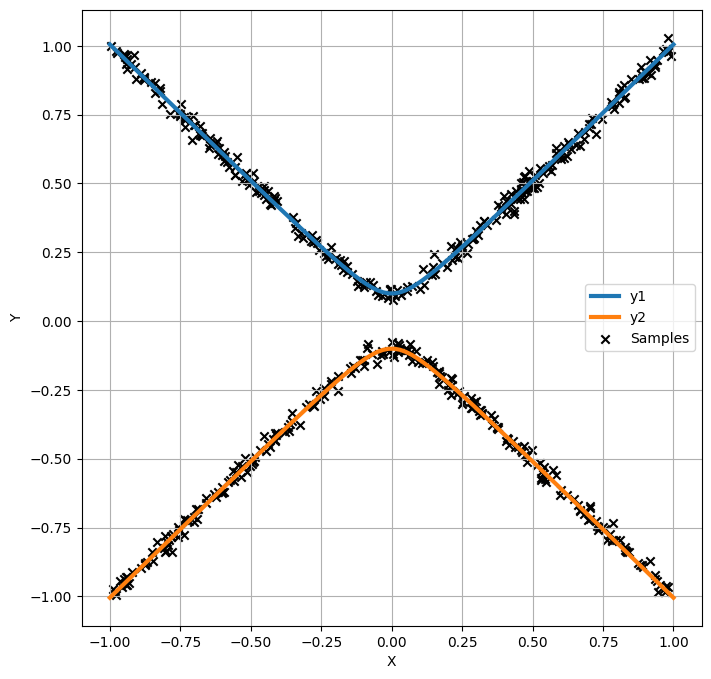

Epoch [1/20], Energy Loss: 5.5099, Generator Loss: -1.7349, Generator Loss (Only G): -0.0010, Gradient Penalty: 0.0000, Diversity: 1.7358, 


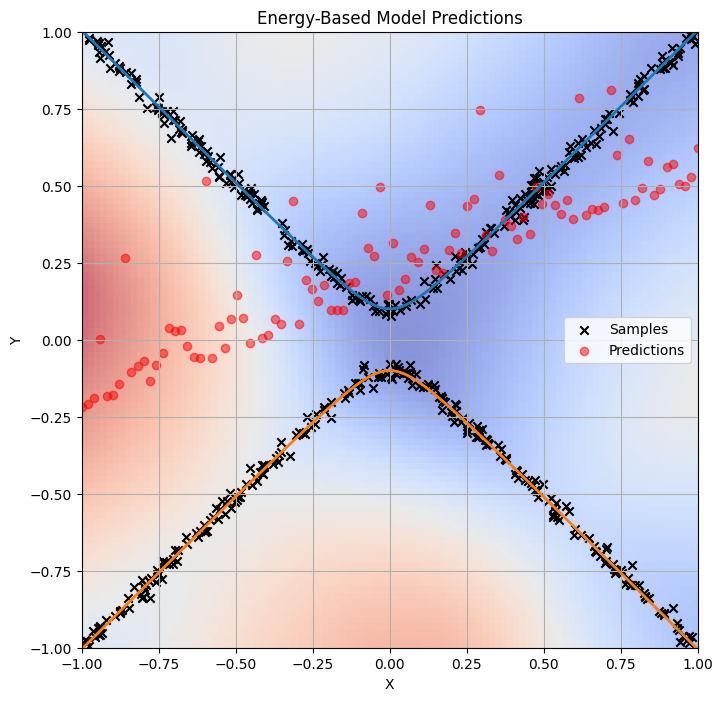

Epoch [2/20], Energy Loss: 5.4274, Generator Loss: -1.6116, Generator Loss (Only G): -0.0665, Gradient Penalty: 0.0000, Diversity: 1.6781, 
Epoch [3/20], Energy Loss: 5.3213, Generator Loss: -2.1626, Generator Loss (Only G): 0.3259, Gradient Penalty: 0.0000, Diversity: 1.8366, 
Epoch [4/20], Energy Loss: 5.1915, Generator Loss: -2.3849, Generator Loss (Only G): 0.5519, Gradient Penalty: 0.0000, Diversity: 1.8330, 
Epoch [5/20], Energy Loss: 5.0657, Generator Loss: -3.1413, Generator Loss (Only G): 1.3277, Gradient Penalty: 0.0000, Diversity: 1.8136, 


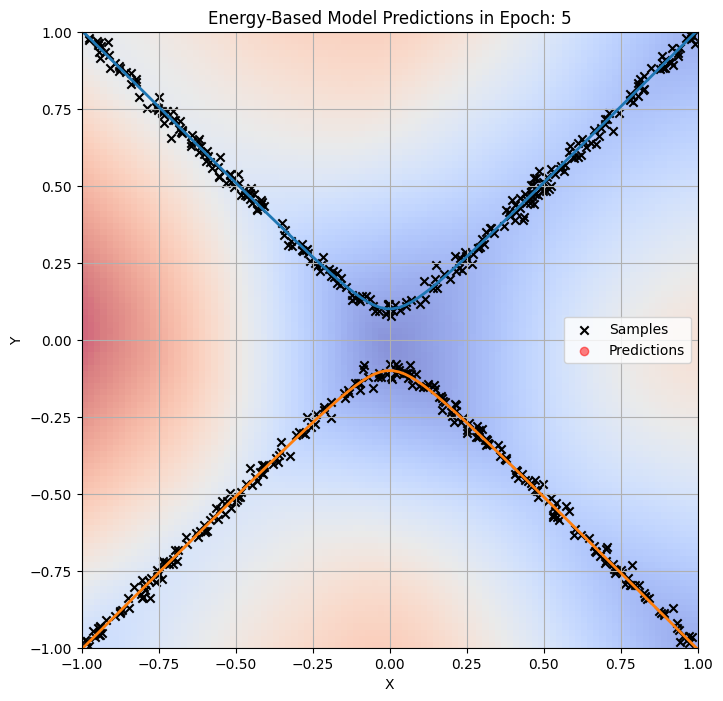

Epoch [6/20], Energy Loss: 4.9174, Generator Loss: -4.1653, Generator Loss (Only G): 2.3283, Gradient Penalty: 0.0000, Diversity: 1.8370, 
Epoch [7/20], Energy Loss: 4.8089, Generator Loss: -6.6007, Generator Loss (Only G): 4.7665, Gradient Penalty: 0.0000, Diversity: 1.8341, 
Epoch [8/20], Energy Loss: 4.6920, Generator Loss: -9.5496, Generator Loss (Only G): 7.7163, Gradient Penalty: 0.0000, Diversity: 1.8333, 


KeyboardInterrupt: 

In [138]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset

# Energy-based Model
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        # self.energy_net = nn.Sequential(
        #     nn.Linear(input_size + action_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, 1)
        # )
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, action_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size + condition_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            # nn.Linear(hidden_size, hidden_size),
            # nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, action_size)
        )

        

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y) # condition, data
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    return [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min 
            for _ in range(neg_count)]
    
def compute_gram_matrix(vectors):
    similarity = torch.mm(vectors, vectors.t())  # Dot product
    norms = torch.norm(vectors, dim=1, keepdim=True)
    gram_matrix = similarity / (norms @ norms.t() + 1e-8)  # Avoid division by zero
    return torch.sigmoid(gram_matrix)  # Scale to (0, 1)

def compute_diversity_penalty(generator, latent_vectors, fixed_condition, device):
    # Compute generated features
    generated_features = generator(latent_vectors, fixed_condition)
    
    # Compute Gram matrices
    G_z = compute_gram_matrix(latent_vectors)
    G_f = compute_gram_matrix(generated_features)
    
    # Calculate diversity penalty
    diversity_penalty = (G_f / (G_z + 1e-8)).mean()
    return diversity_penalty

def compute_gradient_penalty(energy_model, condition, real_samples, fake_samples, device, lambda_gp=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    Args:
        energy_model (nn.Module): The energy-based model.
        condition (Tensor): The condition on which the model is build on.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        device (torch.device): The device (CPU or GPU).
        lambda_gp (float): Coefficient for the gradient penalty.

    Returns:
        Tensor: The gradient penalty term.
    """
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)  # Match dimensions
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute energy model output for interpolated samples
    interpolated_energy = energy_model(condition, interpolated)

    # Compute gradients of energy model output with respect to interpolated samples
    gradients = torch.autograd.grad(
        outputs=interpolated_energy,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_energy, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute L2 norm of gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Gradient penalty term
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

# Training function
def train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, 
          num_epochs, writer, y_min, y_max, neg_count, repeat_energy_updates, device, lambda_gp = 10, diversity_weight = 0.1, max_noise_scale = 0.1, eval_image_time = 25):
    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss = 0.0
        epoch_g_loss_i = 0.0
        epoch_g_penalty = 0.0
        epoch_diversity = 0.0
        i = 0
        noise_scale = max(max_noise_scale, 1 - epoch / num_epochs) if max_noise_scale > 0 else 0
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.float().to(device) # conditon
            y_target = batch_y.float().to(device) # real data
            
            # Update energy model
            for _ in range(repeat_energy_updates):
                # Generate counter samples
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Add generator samples to counter samples
                z = torch.rXndn(x_input.size(0), generator.latent_size, device=device) * noise_scale

                with torch.no_grad():
                    fake_y = generator(z, x_input) # fake data
                counter_samples.append(fake_y)
                
                # Compute energy model loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples)
                
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()
            
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size, device=device)
            
            fake_y = generator(z, x_input)
            g_loss = torch.mean(energy_model(x_input, fake_y))
            epoch_g_loss_i += g_loss.item()
            
            # Add gradient penalty
            gradient_penalty = compute_gradient_penalty(energy_model, x_input, y_target, fake_y, device, lambda_gp)
            # g_loss += gradient_penalty
            
            # Add diversity loss
            # z1, z2 = torch.randn(x_input.size(0), generator.latent_size, device=device), torch.randn(x_input.size(0), generator.latent_size, device=device)
            # fake_y1, fake_y2 = generator(z1, x_input), generator(z2, x_input)
            # diversity_loss = -torch.mean(torch.norm(fake_y1 - fake_y2, dim=-1))

            # Standard generator loss
            fake_y = generator(z, x_input)
            g_loss = -torch.mean(energy_model(x_input, fake_y))

            # Add diversity penalty
            diversity_penalty = compute_diversity_penalty(generator, z, x_input, device)
            g_loss -= diversity_weight * diversity_penalty
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_g_loss += g_loss.item()
            epoch_g_penalty += gradient_penalty.item()
            epoch_diversity += diversity_penalty.item()
            
            # Log losses
            writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)
            i+=1
        
        scheduler_e.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_g_loss_i = epoch_g_loss_i / len(dataloader)
        avg_g_pen = epoch_g_penalty / len(dataloader)
        avg_div = epoch_diversity / len(dataloader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Energy Loss: {avg_e_loss:.4f}, "
              f"Generator Loss: {avg_g_loss:.4f}, "
              f"Generator Loss (Only G): {avg_g_loss_i:.4f}, "
              f"Gradient Penalty: {avg_g_pen:.4f}, "
              f"Diversity: {avg_div:.4f}, ")
        
        if (epoch + 1 == 1) or (epoch + 1) %eval_image_time == 0: 
            visualize_training(generator, energy_model, y_multi, x, y, device, epoch, save_path="visualizations")


parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size_e = 400
hidden_size_g = 500
latent_size = 1
output_size = 1

num_epochs = 20
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

eval_image_time = 5

learning_rate_e = 0.0005 # 0.001
learning_rate_g = 0.0005
lambda_gp = 0
diversity_weight = 1
max_noise_scale = 0

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size_g, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size_e).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)


import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device, lambda_gp = lambda_gp, diversity_weight = diversity_weight, max_noise_scale = max_noise_scale, eval_image_time = eval_image_time)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

# Gradient clipping

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset

# Energy-based Model
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        # self.energy_net = nn.Sequential(
        #     nn.Linear(input_size + action_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, 1)
        # )
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, action_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size + condition_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            # nn.Linear(hidden_size, hidden_size),
            # nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, action_size)
        )

        

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y) # condition, data
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    return [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min 
            for _ in range(neg_count)]
    

def compute_gradient_penalty(energy_model, condition, real_samples, fake_samples, device, lambda_gp=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    Args:
        energy_model (nn.Module): The energy-based model.
        condition (Tensor): The condition on which the model is build on.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        device (torch.device): The device (CPU or GPU).
        lambda_gp (float): Coefficient for the gradient penalty.

    Returns:
        Tensor: The gradient penalty term.
    """
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)  # Match dimensions
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute energy model output for interpolated samples
    interpolated_energy = energy_model(condition, interpolated)

    # Compute gradients of energy model output with respect to interpolated samples
    gradients = torch.autograd.grad(
        outputs=interpolated_energy,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_energy, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute L2 norm of gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Gradient penalty term
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

# Training function
def train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, 
          num_epochs, writer, y_min, y_max, neg_count, repeat_energy_updates, device, lambda_gp = 10, diversity_weight = 0.1, max_noise_scale = 0.1, eval_image_time = 25):
    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss = 0.0
        epoch_g_loss_i = 0.0
        epoch_g_penalty = 0.0
        epoch_diversity = 0.0
        i = 0
        noise_scale = max(max_noise_scale, 1 - epoch / num_epochs) if max_noise_scale > 0 else 0
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.float().to(device) # conditon
            y_target = batch_y.float().to(device) # real data
            
            # Update energy model
            for _ in range(repeat_energy_updates):
                # Generate counter samples
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Add generator samples to counter samples
                z = torch.randn(x_input.size(0), generator.latent_size, device=device) * noise_scale

                with torch.no_grad():
                    fake_y = generator(z, x_input) # fake data
                counter_samples.append(fake_y)
                
                # Compute energy model loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples)
                
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()
            
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size, device=device)
            
            fake_y = generator(z, x_input)
            g_loss = torch.mean(energy_model(x_input, fake_y))
            epoch_g_loss_i += g_loss.item()
            
            # Add gradient penalty
            gradient_penalty = compute_gradient_penalty(energy_model, x_input, y_target, fake_y, device, lambda_gp)
            # g_loss += gradient_penalty
            
            # Add diversity loss
            # z1, z2 = torch.randn(x_input.size(0), generator.latent_size, device=device), torch.randn(x_input.size(0), generator.latent_size, device=device)
            # fake_y1, fake_y2 = generator(z1, x_input), generator(z2, x_input)
            # diversity_loss = -torch.mean(torch.norm(fake_y1 - fake_y2, dim=-1))

            # Standard generator loss
            fake_y = generator(z, x_input)
            g_loss = -torch.mean(energy_model(x_input, fake_y))

            # Add diversity penalty
            diversity_penalty = compute_diversity_penalty(generator, z, x_input, device)
            g_loss -= diversity_weight * diversity_penalty
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_g_loss += g_loss.item()
            epoch_g_penalty += gradient_penalty.item()
            epoch_diversity += diversity_penalty.item()
            
            # Log losses
            writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)
            i+=1
        
        scheduler_e.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_g_loss_i = epoch_g_loss_i / len(dataloader)
        avg_g_pen = epoch_g_penalty / len(dataloader)
        avg_div = epoch_diversity / len(dataloader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Energy Loss: {avg_e_loss:.4f}, "
              f"Generator Loss: {avg_g_loss:.4f}, "
              f"Generator Loss (Only G): {avg_g_loss_i:.4f}, "
              f"Gradient Penalty: {avg_g_pen:.4f}, "
              f"Diversity: {avg_div:.4f}, ")
        
        if (epoch + 1 == 1) or (epoch + 1) %eval_image_time == 0: 
            visualize_training(generator, energy_model, y_multi, x, y, device, epoch, save_path="visualizations")


parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size_e = 400
hidden_size_g = 500
latent_size = 1
output_size = 1

num_epochs = 20
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

eval_image_time = 5

learning_rate_e = 0.0005 # 0.001
learning_rate_g = 0.0005
lambda_gp = 0
diversity_weight = 1
max_noise_scale = 0

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size_g, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size_e).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)


import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device, lambda_gp = lambda_gp, diversity_weight = diversity_weight, max_noise_scale = max_noise_scale, eval_image_time = eval_image_time)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

# Contrastive loss

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset

# Energy-based Model
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, action_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y) # condition, data
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    return [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min 
            for _ in range(neg_count)]
    
def compute_gradient_penalty(energy_model, condition, real_samples, fake_samples, device, lambda_gp=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    Args:
        energy_model (nn.Module): The energy-based model.
        condition (Tensor): The condition on which the model is build on.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        device (torch.device): The device (CPU or GPU).
        lambda_gp (float): Coefficient for the gradient penalty.

    Returns:
        Tensor: The gradient penalty term.
    """
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)  # Match dimensions
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute energy model output for interpolated samples
    interpolated_energy = energy_model(condition, interpolated)

    # Compute gradients of energy model output with respect to interpolated samples
    gradients = torch.autograd.grad(
        outputs=interpolated_energy,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_energy, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute L2 norm of gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Gradient penalty term
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

# Training function
def train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e, 
          num_epochs, writer, y_min, y_max, neg_count, repeat_energy_updates, device, lambda_gp = 10, diversity_weight = 0.1, max_noise_scale = 0.1, eval_image_time = 25):
    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss = 0.0
        epoch_g_loss_i = 0.0
        epoch_g_penalty = 0.0
        epoch_diversity = 0.0
        i = 0
        noise_scale = max(max_noise_scale, 1 - epoch / num_epochs) if max_noise_scale > 0 else 0
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.float().to(device) # conditon
            y_target = batch_y.float().to(device) # real data
            
            # Update energy model
            for _ in range(repeat_energy_updates):
                # Generate counter samples
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Add generator samples to counter samples
                z = torch.randn(x_input.size(0), generator.latent_size, device=device) * noise_scale

                with torch.no_grad():
                    fake_y = generator(z, x_input) # fake data
                counter_samples.append(fake_y)
                
                # Compute energy model loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples)
                
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()
            
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size, device=device)
            
            fake_y = generator(z, x_input)
            g_loss = torch.mean(energy_model(x_input, fake_y))
            epoch_g_loss_i += g_loss.item()
            
            # Add gradient penalty
            gradient_penalty = compute_gradient_penalty(energy_model, x_input, y_target, fake_y, device, lambda_gp)
            # g_loss += gradient_penalty
            
            # Add diversity loss
            z1, z2 = torch.randn(x_input.size(0), generator.latent_size, device=device), torch.randn(x_input.size(0), generator.latent_size, device=device)
            fake_y1, fake_y2 = generator(z1, x_input), generator(z2, x_input)
            diversity_loss = -torch.mean(torch.norm(fake_y1 - fake_y2, dim=-1))
            g_loss += diversity_weight * diversity_loss

            diversity_loss = -torch.var(generator(z, x_input), dim=0).mean()
            g_loss += diversity_weight * diversity_loss
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
            epoch_g_loss += g_loss.item()
            epoch_g_penalty += gradient_penalty.item()
            epoch_diversity += diversity_loss.item()
            
            # Log losses
            writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)
            i+=1
        
        scheduler_e.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_g_loss_i = epoch_g_loss_i / len(dataloader)
        avg_g_pen = epoch_g_penalty / len(dataloader)
        avg_div = epoch_diversity / len(dataloader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Energy Loss: {avg_e_loss:.4f}, "
              f"Generator Loss: {avg_g_loss:.4f}, "
              f"Generator Loss (Only G): {avg_g_loss_i:.4f}, "
              f"Gradient Penalty: {avg_g_pen:.4f}, "
              f"Diversity: {avg_div:.4f}, ")
        
        if (epoch + 1 == 1) or (epoch + 1) %eval_image_time == 0: 
            visualize_training(generator, energy_model, y_multi, x, y, device, epoch, save_path="visualizations")


parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size = 64
latent_size = 1
output_size = 1

num_epochs = 20
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

eval_image_time = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005
lambda_gp = 0
diversity_weight = 0.02
max_noise_scale = 1

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size).to(device)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)


import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train
train(dataloader, generator, energy_model, optimizer_g, optimizer_e, scheduler_e,
        num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, 
        repeat_energy_updates, device, lambda_gp = lambda_gp, diversity_weight = diversity_weight, max_noise_scale = max_noise_scale, eval_image_time = eval_image_time)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, 'generator.pth'))
torch.save(energy_model.state_dict(), os.path.join(log_dir, 'energy_model.pth'))

writer.close()

y1, y2 = real_samples[:, :1], real_samples[:, 1:]
fake_y1, fake_y2 = generator(z1, x_input), generator(z2, x_input)
contrastive_loss = torch.mean(torch.abs(fake_y1 - fake_y2))
e_loss += contrastive_weight * contrastive_loss

True


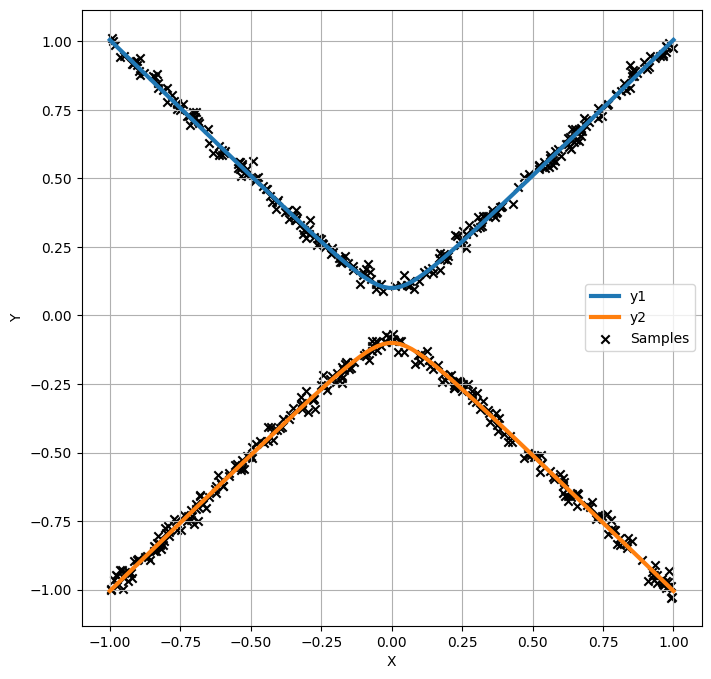

/Users/juliabarth/Desktop/MultiModLearn/deeplearning/lib/python3.12/site-packages/torch/autograd/__init__.py:266: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/juliabarth/Desktop/MultiModLearn/deeplearning/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/juliabarth/Desktop/MultiModLearn/deeplearning/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/juliabarth/Desktop/MultiModLearn/deeplearning/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/Users/juliabarth/Desktop/MultiModLearn/deeplearning/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/Users/j

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [64, 1]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset
torch.autograd.set_detect_anomaly(True)

# Energy-based Model
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)
    
# Statistics Network for Info Loss
class StatisticsNetwork(nn.Module):
    def __init__(self, y_dim, z_dim, hidden_dim):
        super(StatisticsNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(y_dim + z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Outputs log_q_phi(z|y)
        )

    def forward(self, y, z):
        combined = torch.cat([y, z], dim=-1)
        return self.network(combined)

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, action_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# InfoNCE-style loss function
# def info_nce_loss(energy_model, x, y, counter_samples):
#     positive_energy = -energy_model(x, y) # condition, data
#     neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
#     denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
#     return torch.mean(denominator - positive_energy)

def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y)  # condition, data
    neg_energies = torch.stack([-energy_model(x, neg.clone()) for neg in counter_samples], dim=1)  # Avoid in-place modification
    denominator = torch.logsumexp(
        torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1
    )
    return torch.mean(denominator - positive_energy)


# def compute_info_loss(generator, stats_network, z_values, fixed_x_tensor):
#     """
#     Compute the Info Loss to maximize mutual information between z and G(z, x).
#     """
#     # Generator outputs
#     y_generated = generator(z_values, fixed_x_tensor)

#     # Estimate mutual information using the statistics network
#     log_q_phi = stats_network(y_generated, z_values)

#     # Minimize -I(Y; Z) (maximize mutual information)
#     info_loss = -torch.mean(log_q_phi.clone())  # Negate for minimization
#     return info_loss

def compute_info_loss(generator, stats_network, z_values, fixed_x_tensor):
    # Ensure inputs are not modified in-place
    y_generated = generator(z_values.clone(), fixed_x_tensor.clone())

    # Estimate mutual information using the statistics network
    log_q_phi = stats_network(y_generated, z_values.clone())  # Avoid reusing z_values

    # Minimize -I(Y; Z) (maximize mutual information)
    info_loss = -torch.mean(log_q_phi)  # Negate for minimization
    return info_loss


# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    return [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min 
            for _ in range(neg_count)]
    
def compute_gradient_penalty(energy_model, condition, real_samples, fake_samples, device, lambda_gp=10):
    """
    Compute the gradient penalty for WGAN-GP.
    
    Args:
        energy_model (nn.Module): The energy-based model.
        condition (Tensor): The condition on which the model is build on.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        device (torch.device): The device (CPU or GPU).
        lambda_gp (float): Coefficient for the gradient penalty.

    Returns:
        Tensor: The gradient penalty term.
    """
    # Interpolate between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)  # Match dimensions
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute energy model output for interpolated samples
    interpolated_energy = energy_model(condition, interpolated)

    # Compute gradients of energy model output with respect to interpolated samples
    gradients = torch.autograd.grad(
        outputs=interpolated_energy,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_energy, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute L2 norm of gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Gradient penalty term
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty


def train_with_info_loss(
    dataloader, generator, energy_model, stats_network, optimizer_g, optimizer_e, optimizer_s, scheduler_e,
    num_epochs, writer, y_min, y_max, neg_count, repeat_energy_updates, device, 
    lambda_gp=0, diversity_weight=0.0, info_weight=1.0, max_noise_scale=0, eval_image_time=5
):
    for epoch in range(num_epochs):
        epoch_e_loss, epoch_g_loss, epoch_info_loss, epoch_diversity = 0.0, 0.0, 0.0, 0.0
        i = 0
        noise_scale = max(max_noise_scale, 1 - epoch / num_epochs) if max_noise_scale > 0 else 0

        for batch_x, batch_y in dataloader:
            x_input = batch_x.float().to(device)  # Condition
            y_target = batch_y.float().to(device)  # Real data

            # ---------------------
            # Update Energy Model
            # ---------------------
            for _ in range(repeat_energy_updates):
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                z = torch.randn(x_input.size(0), generator.latent_size, device=device) * noise_scale

                with torch.no_grad():
                    fake_y = generator(z, x_input)
                counter_samples.append(fake_y)

                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples)

                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                epoch_e_loss += e_loss.item()

            # ---------------------
            # Update Generator
            # ---------------------
            z = torch.randn(x_input.size(0), generator.latent_size, device=device)
            fake_y = generator(z, x_input)

            # Generator Loss: Energy + Diversity + Info Loss
            g_loss = torch.mean(energy_model(x_input, fake_y))

            # Diversity Loss
            z1, z2 = torch.randn_like(z), torch.randn_like(z)
            fake_y1, fake_y2 = generator(z1, x_input), generator(z2, x_input)
            diversity_loss = -torch.mean(torch.norm(fake_y1 - fake_y2, dim=-1))
            g_loss += diversity_weight * diversity_loss
            epoch_diversity += diversity_loss.item()

            # Info Loss
            info_loss = compute_info_loss(generator, stats_network, z, x_input)
            g_loss += info_weight * info_loss

            optimizer_g.zero_grad()
            g_loss.backward(retain_graph=True)
            optimizer_g.step()

            epoch_g_loss += g_loss.item()
            epoch_info_loss += info_loss.item()

            # ---------------------
            # Update Statistics Network
            # ---------------------
            stats_network_loss = -info_loss  # Maximize mutual information
            optimizer_s.zero_grad()
            stats_network_loss.backward()
            optimizer_s.step()

            # Log losses
            writer.add_scalar("Loss/EnergyModel", e_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar("Loss/Generator", g_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar("Loss/Info", info_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar("Loss/Diversity", diversity_loss.item(), epoch * len(dataloader) + i)
            i += 1

        scheduler_e.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_info_loss = epoch_info_loss / len(dataloader)
        avg_diversity = epoch_diversity / len(dataloader)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Energy Loss: {avg_e_loss:.4f}, "
              f"Generator Loss: {avg_g_loss:.4f}, "
              f"Info Loss: {avg_info_loss:.4f}, "
              f"Diversity Loss: {avg_diversity:.4f}")

        if (epoch + 1) % eval_image_time == 0:
            visualize_training(generator, energy_model, y_multi, x, y, device, epoch, save_path="visualizations")

parser = argparse.ArgumentParser(description='Train Energy-Based GAN model.')
parser.add_argument('--log_dir', type=str, default='logs/hyperbol', help='Directory for tensorboard logs')

# Use parse_known_args to ignore unrecognized arguments
args, unknown = parser.parse_known_args()


# Hyperparameters
action_size = 1
condition_size = 1
hidden_size_e = 64
hidden_size_g = 64
hidden_size_s = 64
latent_size = 1
output_size = 1

num_epochs = 20
batch_size = 32
neg_count = 256
repeat_energy_updates = 1

eval_image_time = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005
learning_rate_s = 0.0005
lambda_gp = 0
diversity_weight = 0.00
max_noise_scale = 0

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create models
generator = Generator(latent_size, hidden_size_g, action_size, condition_size).to(device)
energy_model = EnergyModel(condition_size, action_size, hidden_size_e).to(device)
statist = StatisticsNetwork(action_size, latent_size, hidden_size_s)

# Setup optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_e = optim.Adam(energy_model.parameters(), lr=learning_rate_e)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_e, step_size=20, gamma=0.5)
optimizer_s = optim.Adam(statist.parameters(), lr=learning_rate_s)

# Setup tensorboard
log_dir = os.path.join(args.log_dir, 'ebgan_training')
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)


import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

y_min = torch.tensor([-1]) 
y_max = torch.tensor([1])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()


dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Train
train_with_info_loss(
    dataloader, generator, energy_model, statist, optimizer_g, optimizer_e, optimizer_s, scheduler_e,
    num_epochs, writer, y_min.to(device), y_max.to(device), neg_count, repeat_energy_updates, 
    device, lambda_gp=lambda_gp, diversity_weight=diversity_weight, info_weight=1.0, 
    max_noise_scale=max_noise_scale, eval_image_time=eval_image_time
)

# Save models
torch.save(generator.state_dict(), os.path.join(log_dir, "generator.pth"))
torch.save(energy_model.state_dict(), os.path.join(log_dir, "energy_model.pth"))
torch.save(statist.state_dict(), os.path.join(log_dir, "statist.pth"))

writer.close()
